<img src="https://www.epfl.ch/about/overview/wp-content/uploads/2020/07/logo-epfl-1024x576.png" style="padding-right:10px;width:140px;float:left"></td>
<h2 style="white-space: nowrap">Image Processing Laboratory Notebooks</h2>
<hr style="clear:both">
<p style="font-size:0.85em; margin:2px; text-align:justify">
This Juypter notebook is part of a series of computer laboratories which are designed
to teach image-processing programming; they are running on the EPFL's Noto server. They are the practical complement of the theoretical lectures of the EPFL's Master course <b>Image Processing II</b> 
(<a href="https://moodle.epfl.ch/course/view.php?id=463">MICRO-512</a>) taught by Dr. D. Sage, Dr. M. Liebling, Prof. M. Unser and Prof. D. Van de Ville.
</p>
<p style="font-size:0.85em; margin:2px; text-align:justify">
The project is funded by the Center for Digital Education and the School of Engineering. It is owned by the <a href="http://bigwww.epfl.ch/">Biomedical Imaging Group</a>. 
The distribution or the reproduction of the notebook is strictly prohibited without the written consent of the authors.  &copy; EPFL 2022.
</p>
<p style="font-size:0.85em; margin:0px"><b>Authors</b>: 
    <a href="mailto:pol.delaguilapla@epfl.ch">Pol del Aguila Pla</a>, 
    <a href="mailto:kay.lachler@epfl.ch">Kay Lächler</a>,
    <a href="mailto:alejandro.nogueronaramburu@epfl.ch">Alejandro Noguerón Arámburu</a>,
    <a href="mailto:daniel.sage@epfl.ch">Daniel Sage</a>, and
    <a href="mailto:jaejun.yoo@epfl.ch">Jaejun Yoo</a>.
     
</p>
<hr style="clear:both">
<h1>Lab 7.1: Training deep neural networks</h1>
<div style="background-color:#F0F0F0;padding:4px">
    <p style="margin:4px;"><b>Released</b>: Thursday May 26, 2022</p>
    <p style="margin:4px;"><b>Submission</b>: <span style="color:red">Friday June 10, 2022</span> (before 11:59PM) on <a href="https://moodle.epfl.ch/course/view.php?id=463">Moodle</a></p>
    <p style="margin:4px;"><b>Grade weigth</b>: Lab 7 (28 points), 7.5 % of the overall grade</p>
    <p style="margin:4px;"><b>Remote help</b>: Thursday 2nd of June (on Zoom and ELD 020) and Monday 6th of June, 2022 on Zoom (see Moodle for link)</p>    
    <p style="margin:4px;"><b>Related lectures</b>: Chapter 11</p>
</div>

### Student Name: Guanqun LIU
### SCIPER: 334988

Double-click on this cell and fill your name and SCIPER number. Then, run the cell below to verify your identity in Noto and set the seed for random results.

In [1]:
import getpass
# This line recovers your camipro number to mark the images with your ID
uid = int(getpass.getuser().split('-')[2]) if len(getpass.getuser().split('-')) > 2 else ord(getpass.getuser()[0])
print(f'SCIPER: {uid}')

SCIPER: 334988


## <a name="imports_"></a> Imports
In the next cell we import Python libraries we will use throughout the lab.
* [`matplotlib.pyplot`](https://matplotlib.org/3.2.2/api/_as_gen/matplotlib.pyplot.html), to display images,
* [`ipywidgets`](https://ipywidgets.readthedocs.io/en/latest/), to make the image display interactive,
* [`numpy`](https://numpy.org/doc/stable/reference/index.html), for mathematical operations on arrays,
* [PyTorch (`torch`)](https://pytorch.org/), to compare the results of neural network implementations with those of the same networks implemented in a deep learning framework with automatic differentiation (PyTorch Autograd),
* [`sklearn`](https://scikit-learn.org/stable/), a dedicated machine learning library, that includes data preparation routines and toy datasets.

We will then load the `IPLabViewer` class (see the documentation [here](https://github.com/Biomedical-Imaging-Group/IPLabImageViewer/wiki/Python-IPLabViewer()-Class) or run the Python command `help(viewer)` after loading the class).

In [2]:
# Configure plotting as dynamic
%matplotlib widget

# Import standard required packages for this exercise
import matplotlib.pyplot as plt
import ipywidgets as widgets
import torch 
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from IPython.display import Image

# Training deep neural networks (20 points)

In this lab, you will study the backpropagation algorithm, which is a technique to compute gradients of expressions through the recursive application of the chain rule. You will implement it for simple architectures, and explore how it is built into modern deep learning libraries like [PyTorch (`torch`)](https://pytorch.org/). Understanding this process and its subtleties will be critical for you to effectively develop, design and debug neural networks.

## <a id="ToC_1_NN"></a>Table of contents
1. [The backpropagation algorithm](#1.-The-backpropagation-algorithm)
    1. [Toy example: Affine function](#1.A.-Toy-example:-Affine-function-(5-points)) 
        1. [Numpy implementation](#1.A.a.-Numpy-implementation-(5-points)) **(5 points)**
        2. [PyTorch — Introduction and implementation](#1.A.b.-PyTorch-—-Introduction-and-implementation)
    2. [Toy example: Logistic regression](#1.B.-Toy-example:-Logistic-regression-(6-points)) 
        1. [Numpy implementation](#1.B.a.-Numpy-implementation-(4-points)) **(4 points)**
        2. [PyTorch implementation](#1.B.b.-PyTorch-implementation-(2-points)) **(2 points)**
        3. [PyTorch implementation with higher abstractions](#1.B.c.-PyTorch-implementation-with-higher-abstractions)
2. [Binary Classification](#2.-Binary-Classification)
    1. [PyTorch implementation](#2.A.-PyTorch-Implementation-(9-points)) **(9 points)**
    2. [Visualization](#2.B.-Visualization)

# 1. The backpropagation algorithm
[Back to table of contents](#ToC_1_NN)

[Modern neural network architectures](https://towardsdatascience.com/the-w3h-of-alexnet-vggnet-resnet-and-inception-7baaaecccc96#:~:text=VGG16%20has%20a%20total%20of,with%20a%20stride%20of%20two.) can have millions of *learnable* parameters. Backpropagation is an algorithm that was developed for training this huge number of parameters in an efficient and effective way. The essence of this algorithm is the recursive use of the chain rule from differential calculus — you calculate the derivative of a function that was created by combining other functions for which the derivatives are known. 

It is fine if this does not make any sense to you at this point. We will guide you through every step of this algorithm with a series of simple toy examples.

## 1.A. Toy example: Affine function (5 points)
[Back to table of contents](#ToC_1_NN)

Let's consider a simple network that implements a one-dimensional affine function, where $f(x,\beta_0,\beta_1) = \beta_1 x + \beta_0$ and the squared error loss function $L(\boldsymbol{\beta}) = (f(x,\beta_0,\beta_1)-y)^2$, where $\boldsymbol{\beta}=[\beta_0,\beta_1]$. Here, $x$ is an input of the neural network and $y$ denotes the desired output (label or target). This simple network can be represented as the following computational graph

<table>
<tr>
    <td>
        <p align="center" style="padding: 10px">
            <img src="images/toy-example_affine-function.png" alt="Computational graph of an affine function." style="width: 500px;"><br>
        <em style="color: grey">Computational graph of the network computing the one-dimensional affine function. $a$ and $b$ are two highlighted points in the graph, for use in later explanations. In the diagram $x$ is multiplied by $\beta_1$, which results in the value $a$ and then the constant $\beta_0$ is added to obtain the value $b$. Finally, the loss function $L$ is computed with respect to the correct output $y$.</em>
        </p> 
    </td>
</tr>
</table>

Then, our goal is to train the network, i.e., to find the parameters $\beta_0$ and $\beta_1$ of the affine function, so that the loss function is minimized. From a computational point of view, training a neural network consists of the repetition of two phases

1. the forward pass, to compute the value of the loss function and the intermediate values,
2. the backward pass, to compute the gradients of the loss function with respect to every learnable parameter. These are then used to update the learnable parameters to _better_ values, and the procedure is repeated.

The forward pass is pretty straightforward. The output of one layer is the input of the next, so one computes each operation in the graph from left to right. The backward pass is a bit more complicated: it requires us to use the chain rule to compute **the gradient of the loss function with respect to each of the learnable parameters** (also known as weights). Here, the backward process of this toy-example network can be described by the following formulas

$$ \frac{\partial L}{\partial \beta_0} = \frac{\partial L}{\partial b}\frac{\partial b}{\partial \beta_0}\mbox{, and }\frac{\partial L}{\partial \beta_1} = \frac{\partial L}{\partial b}\frac{\partial b}{\partial a}\frac{\partial a}{\partial \beta_1}\,.$$

We will begin by implementing this chain rule to compute the gradient $\nabla L = \left[\frac{\partial L}{\partial \beta_0}, \frac{\partial L}{\partial \beta_1} \right]^{\mathrm{T}}$. 

<div class="alert alert-info">
    
<b>Note:</b> If you don't remember how the chain rule works, you can revise <a href="https://moodle.epfl.ch/pluginfile.php/2914036/mod_resource/content/1/exercise_8.pdf">the last exercise collection</a>. In any case, read through the code provided below and make sure you understand what each line is doing.
</div> 

<div class="alert alert-danger">
    
<b>Note:</b> In the notation above, we are purposely hiding something away. Where are each of these derivatives evaluated? Make sure you fully understand this before moving on. 
    
</div>

### 1.A.a. Numpy implementation (5 points)
[Back to table of contents](#ToC_1_NN)

Here, you will implement the forward and backward evaluations for the toy example network above using NumPy. You will do this manually, as opposed to using an _autodifferentiation_ package like PyTorch, as we will explore [further below](#1.A.b.-PyTorch-—-Introduction-and-implementation). 

### Forward pass

**For 1 point**, complete the function `model_forward` that defines the forward pass in the cell below.

The function `model_forward` takes as inputs
 * `x`: the input value, 
 * `betas` (tuple of two scalars): the two parameters ($\beta_0$, $\beta_1$),
 
and returns the values $a$ and $b$.

In [3]:
# Perform the forward pass
def model_forward(x, betas):
    # Extract parameters from tuple and initialize a and b
    beta0, beta1 = betas
    a = None
    b = None
    
    # Compute affine function (compute both a and b)
    a = beta1 * x
    b = a + beta0
    
    return a, b

Now, run the next cell to actually perform a forward pass and test your function. We will use the following input values and parameters: $x = -2$, $\beta_0 = 2$, $\beta_1 = -4$, $y = 20$. Verify that your implementation is correct by confirming your results match what you expect.

Run the next cell to test your function with these parameters. 

In [4]:
# Set the values of input and parameters
x = np.array(-2.)
beta0 = np.array(2.)
beta1 = np.array(-4.) 
# Set the value of the target / label
y = np.array(20.)

# Run the forward pass
a, b = model_forward(x, (beta0, beta1))

# Compute the loss for the current output
L = (b - y)**2

# Print results
print(f"Parameters: β₀ = {beta0} and β₁ = {beta1}.\n\
Forward pass, results: a = {a}, b = {b}, with y = {y}, \
resulting in a loss of L = {L}.\n")

# Sanity check
if a != 8:
    print('WARNING!\na is not correct!')  
elif b != 10:
    print('WARNING!\nb is not correct!')  
elif L != 100:
    print('WARNING!\nL is not correct!') 
else:
    print('Congratulations! Your forward pass seems to be working.')

Parameters: β₀ = 2.0 and β₁ = -4.0.
Forward pass, results: a = 8.0, b = 10.0, with y = 20.0, resulting in a loss of L = 100.0.

Congratulations! Your forward pass seems to be working.


By looking at $L$, it is clear that the parameters $\beta_1$ and $\beta_0$ could improve. Let us look further into it. 

### Backward pass

To begin this section, and **for 2 points**, write **the value** of the partial derivatives used in the expression above (**each worth 0.5 points**) when $x=-2$, $y=20$, $\beta_0=2$, and $\beta_1=-4$.

To answer, change the value of the variables `dLdb` (for $\partial L / \partial b$), `dbda` (for $\partial b/\partial a$), `dbdbeta0` (for $\partial b/\partial \beta_0$) and `dadbeta1` (for $\partial a/\partial \beta_1$). To use them later effectively, **provide *NumPy* arrays of shape `(1, )` of floating point type**, as in the example variable `example` below.

Run the four cells after this one to check that your answers are valid.

In [11]:
# dL/db
dLdb = None
# db/da
dbda = None 
# da/dbeta1
dadbeta1 = None
# db/dbeta0
dbdbeta0 = None
 

# For later use, please set the values as floats, with shape (1, ) e.g.,
example = np.array([1.])

# YOUR CODE HERE
dLdb = np.array([-20.])
dbda = np.array([1.])
dbdbeta0 = np.array([1.])
dadbeta1 = np.array([-2.])

<div class="alert alert-info">
    
<b>Note:</b> Now, take the time to consider: following the chain rule we showed you at <a href="#1.A.-Toy-example:-Affine-function-(5-points)">the start of the section</a>, what are the values of $\partial L / \partial \beta_0$ and $\partial L / \partial \beta_1$ in these same conditions? Does this coincide with your manual computations?  
    
</div> 

In [12]:
if type(dLdb) != np.ndarray:
    print('WARNING!!\nMake sure that you provide a NumPy array like in the example variable above.')
if dLdb.shape != (1, ):
    print(f'WARNING!!\nThis is a one-dimensional partial derivative. The shape of the array should be (1, ) instead of {dLdb.shape}.')
if dLdb.dtype != float:
    print('WARNING!!\nMake sure that you provide a floating-point number by ending whole numbers in a dot like in the example variable above.')

In [13]:
if type(dbda) != np.ndarray:
    print('WARNING!!\nMake sure that you provide a NumPy array like in the example variable above.')
if dbda.shape != (1, ):
    print(f'WARNING!!\nThis is a one-dimensional partial derivative. The shape of the array should be (1, ) instead of {dbda.shape}.')
if dbda.dtype != float:
    print('WARNING!!\nMake sure that you provide a floating-point number by ending whole numbers in a dot like in the example variable above.')

In [14]:
if type(dadbeta1) != np.ndarray:
    print('WARNING!!\nMake sure that you provide a NumPy array like in the example variable above.')
if dadbeta1.shape != (1, ):
    print(f'WARNING!!\nThis is a one-dimensional partial derivative. The shape of the array should be (1, ) instead of {dadbeta1.shape}.')
if dadbeta1.dtype != float:
    print('WARNING!!\nMake sure that you provide a floating-point number by ending whole numbers in a dot like in the example variable above.')

In [15]:
if type(dbdbeta0) != np.ndarray:
    print('WARNING!!\nMake sure that you provide a NumPy array like in the example variable above.')
if dbdbeta0.shape != (1, ):
    print(f'WARNING!!\nThis is a one-dimensional partial derivative. The shape of the array should be (1, ) instead of {dbdbeta0.shape}.')
if dbdbeta0.dtype != float:
    print('WARNING!!\nMake sure that you provide a floating-point number by ending whole numbers in a dot like in the example variable above.')

Now, **for 2 points**, complete the function `model_forward_backward` below, which implements the forward and backward passes of the toy example network above, and **works for arbitrary values of $x$, $y$, $\beta_0$ and $\beta_1$**. Your function will take as parameters
* `x`: the input value,
* `y`: the target or label value,
* `betas`: the parameters $\beta_0$ and $\beta_1$, given in a tuple like `betas=(beta0,beta1)`,

and will output the value of the loss function and its derivatives with respect to $\beta_0$ and $\beta_1$ (its gradient with respect to the weights). Follow the comments that will guide you on how to calculate $\partial L / \partial \beta_0$ and $\partial L / \partial \beta_1$ (if in doubt, you can reread [Section 1.A](#1.A.-Toy-example:-Affine-function-(5-points))).

<div class = 'alert alert-info'>

<b>Hint:</b> You can reuse your function `model_forward(x, betas)` here.
</div>

In [20]:
# Perform the forward pass and the backward pass (backpropagation)
def model_forward_backward(x, y, betas):    
    # Extract parameters from tuple
    beta0, beta1 = betas
    
    # Initialize variables (make sure to change all their values)
    a = None
    b = None
    L = None
    dLdb = None 
    dbdbeta0 = None
    dLdbeta0 = None
    dbda = None
    dadbeta1 = None
    dLdbeta1 = None
    
    # Perform the forward pass    
    a, b = model_forward(x, betas)
    
    # Compute the value of the loss function
    L = (b - y) ** 2
    
    # Perform the backward pass - backpropagate through L and b - to find dLdbeta0 and dLdbeta1.
    # To find dLdbeta0 you will need dLdb and dbdbeta0
    # Compute dLdb using b and y
    dLdb = 2 * (b - y)
    
    # Compute dbdbeta0
    dbdbeta0 = 1
    
    # Compute dLdbeta0 using dLdb and dbdbeta0   
    dLdbeta0 = dLdb * dbdbeta0
    
    # Great! Now you are just missing dLdbeta1. You will need dbda and dadbeta1 (you already have dLdb) 
    # Compute dbda
    dbda = 1
    
    # Compute dadbeta1    
    dadbeta1 = x
    
    # Compute dLdbeta1 using dLdb, dbda, dadbeta1    
    dLdbeta1 = dLdb * dbda * dadbeta1
    
    return L, (dLdbeta0, dLdbeta1)

Run the following cell to test your function. We will first test with the original parameters we were using before, i.e., $x=-2$, $y=20$, $\beta_0=2$, and $\beta_1=-4$.

However, there are sliders so that you can change the values to whatever you want. Click the button `Forward Backward` to rerun `model_forward_backward` with the new parameters and update the textbox. 

<div class = 'alert alert-warning'>

<b>Note</b>: The sanity check on your function will appear when you first run the cell. <b>Look at the textbox before changing the parameters!</b> If your function has any problem, try to work out the math manually and find the error in your code.
</div>

In [21]:
# Declare widgets
x_slider = widgets.FloatSlider(value = -2, min = -20, max = 20, step = 0.1, description = r'$x$')
y_slider = widgets.FloatSlider(value = 20, min = -20, max = 20, step = 0.1, description = r'$y$')
beta0_slider = widgets.FloatSlider(value = 2, min = -20, max = 20, step = 0.1, description = r'$\beta_0$')
beta1_slider = widgets.FloatSlider(value = -4, min = -20, max = 20, step = 0.1, description = r'$\beta_1$')
text_box = widgets.Textarea(value = '', layout={'width': '500px', 'height': '70px'})
button = widgets.Button(description = 'Forward Backward')

def interact(change):
    '''
    Function that gets values of widgets and calls forward and backward pass
    '''
    x = x_slider.value
    y = y_slider.value
    beta0 = beta0_slider.value
    beta1 = beta1_slider.value
    
    L, (dLdbeta0, dLdbeta1) = model_forward_backward(x, y, (beta0, beta1))
    # Test your function when you first run the cell
    if x == -2 and y == 20 and beta0 == 2 and beta1 == -4:
        string = ''
        if not np.isclose(L, 100): string += f'L is not correct. Should be 100 instead of {L}\n'
        if not np.isclose(dLdbeta0, -20): string += f'dL/dβ₀ is not correct. Should be -20 instead of {dLdbeta0}\n'
        if not np.isclose(dLdbeta1, 40): string += f'dL/dβ₁ is not correct. Should be 40 instead of {dLdbeta1}\n'
        if not string == '': string = 'WARNING:\n' + string
        else: string = 'Congratulations! Your function seems correct.\n'
        text_box.value = string + f'Values: x = {x}, y = {y}, β₀ = {beta0}, β₁ = {beta1}\n\
Results: L = {L}, dL/dβ₀ = {dLdbeta0}, dL/dβ₁ = {dLdbeta1}'
        
    # Display any other values
    else:
        text_box.value = f'Values: x = {x:.2f}, y = {y:.2f}, β₀ = {beta0:.2f}, β₁ = {beta1:.2f}\n\
Results: L = {np.round(L, 2)}, dL/dβ₀ = {np.round(dLdbeta0, 2)}, dL/dβ₁ = {np.round(dLdbeta1, 2)}'

# Link button to function and display all widgets
button.on_click(interact)
display(widgets.HBox([widgets.VBox([x_slider, y_slider, beta0_slider, beta1_slider]), 
                      widgets.VBox([text_box, button])]))
button.click()

<div class=" alert alert-info">
    
<b>Note:</b> Regardless of the sanity check, does the math work out? What does each of the partial derivatives mean here? Did you try to work out an example where the loss is zero?
    
So far we have defined and implemented the architecture of our toy example, and calculated one forward and backward pass to work out the gradients of the loss $L$ with respect to the weights $\beta_0$ and $\beta_1$. In the next section, we will see how to change the values of $\beta_0$ and $\beta_1$ to reduce the loss.
</div> 

### Gradient descent

Our goal is to find the values of $\beta_0$ and $\beta_1$ that minimize the loss function. We can exploit $\partial L/\partial \beta_0$ and $\partial L/\partial \beta_1$ for a [gradient descent algorithm](https://en.wikipedia.org/wiki/Gradient_descent), one of the simplest and most fundamental optimization algorithms in machine learning (ML), science, and engineering. The general idea is to update a parameter (for example, a vector $\boldsymbol{\alpha}$) in the direction that minimizes the gradient of a function $f$. The parameter $\boldsymbol{\alpha}_t$ at iteration $t+1$, then, is given by the following update rule

$$\boldsymbol{\alpha}_{t+1} \leftarrow \boldsymbol{\alpha}_t - \gamma \nabla_{\boldsymbol{\alpha}} f(\boldsymbol{\alpha}_t)\,.$$

In our context, $f=L$ is the loss function and $\gamma$ is the *learning rate*, an [hyperparameter](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)) to be chosen by the user. The gradient $\nabla_{\boldsymbol{\alpha}}$ is taken with respect to the parameter, which explains why we need to perform a backward pass and extract $\frac{\partial L}{\partial \beta_0}$ and $\frac{\partial L}{\partial \beta_1}$ in our toy example.

Run the next cell to declare the function `gradient_descent`, and make sure to understand it completely.

In [22]:
def gradient_descent(learning_rate, betas, gradient):
    # Extract parameters and partial derivatives
    beta0, beta1 = betas
    dLdbeta0, dLdbeta1 = gradient
    # Take gradient step
    beta0_updated = beta0 - learning_rate * dLdbeta0
    beta1_updated = beta1 - learning_rate * dLdbeta1
    # Return updated parameters
    return beta0_updated, beta1_updated

Now run the following cell, where we will redeclare our parameters with the original values defined at the beginning of [Section 1.A.a](#1.A.a.-Numpy-implementation-(5-points)) and perform one step of the gradient descent algorithm. Observe what happens when running the cell, and go trough every line of code. Note that we have arbitrarily chosen `learning_rate = 1e-2`. 

In [23]:
# Set the value of input
x = np.array(-2.)
# Set the value of the target / label
y = np.array(20.)
# Set the initial parameters 
beta0 = np.array(2.)
beta1 = np.array(-4.) 
betas = (beta0, beta1)
# Set the learning rate for the gradient descent step
learning_rate = 1e-2

# Make a forward - backward pass
L, gradient = model_forward_backward(x, y, betas)
# Take the gradient descent step
betas_new = gradient_descent(learning_rate, betas, gradient)

# Make a forward pass to evaluate the new loss function
a, b = model_forward(x, betas_new)
# Compute the loss after the update
L_new = (b-y)**2

print(f'Initial condition: β₀ = {beta0}, β₁ = {beta1},  L = {L}.')
print(f'Updated condition: β₀ = {betas_new[0]}, β₁ = {betas_new[1]},  L = {L_new}.')
if L_new < L:
    print(f'Congratulations! Your loss function has been reduced from {L} to {L_new}.')
else:
    raise Exception(f'Check your implementation: your loss went up from {L} to {L_new} after an iteration of gradient descent.')

Initial condition: β₀ = 2.0, β₁ = -4.0,  L = 100.0.
Updated condition: β₀ = 2.2, β₁ = -4.4,  L = 81.0.
Congratulations! Your loss function has been reduced from 100.0 to 81.0.


Now, we will actually let gradient descent run until convergence (or for a larger number of steps). In the next cell, we will plot the evolution of the loss and of the parameters $\beta_0$ and $\beta_1$ with every iteration of the algorithm. Now: you might be asking yourself what to do about the learning rate. Indeed, it is a parameter that, when the shape of the loss function is unknown, has to be tuned manually and can take a wide range of values. After running the next cell, you will find several sliders and two buttons:

* `gamma_value`: to choose the value of the learning rate,
* `gamma_decimal`: to choose the order of magnitude of the learning rate,
* `iterations_slider`: to choose the number of iterations for which gradient descent will be run,
* `button` and `button_res`: to run gradient descent once more and to clear the plot, respectively.

Go carefully through the function `gradient_descent_full_run` to see how we run the algorithm. Then run the cell to interactively see the performance (note that we are working with the same parameters we declared at the beginning of [Section 1.A.a](#1.A.a.-Numpy-implementation-(5-points))). 

<div class = 'alert alert-warning'>

<b>Hint</b>: Play with different values of the learning rate, and you can see how important it is to choose an appropiate one. To clear the axes, click the button `Clear Axes`. You can see the learning rate that you are about to choose in the box between the sliders.
</div>

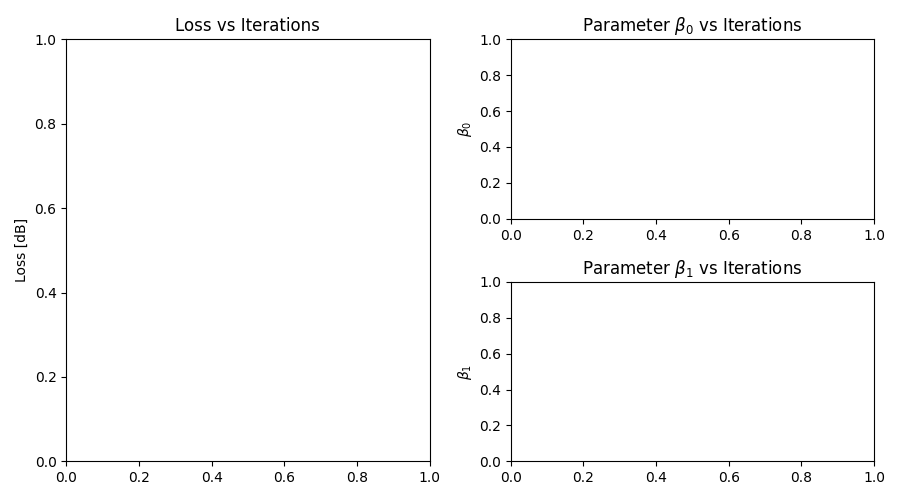

In [24]:
# Declare sliders
gamma_value = widgets.IntSlider(value = 1, min = 1, max = 10, step = 1, description = r'$\gamma$ val.')
gamma_decimal = widgets.IntSlider(value = -2, min = -5, max = 5, step = 1, description = r'1E')
lr_textbox = widgets.Textarea(value = f'{10**-2:.0E}', description = r'$\gamma =$', layout = {'width': '200px', 'height': '30px'})
iterations_slider = widgets.IntSlider(value = 100, min = 10, max = 500, step = 10, description = 'Iterations')
table = widgets.Textarea(value = '', layout = {'width': '55%', 'height': '300px'})
button = widgets.Button(description = 'Run GD')
button_res = widgets.Button(description='Clear Axes')
# Prepare display
box = widgets.HBox([table, widgets.VBox([gamma_value, gamma_decimal, lr_textbox, iterations_slider, button, button_res])])

# Declare figure to plot evolution of parameters
plt.close('all')
fig = plt.figure(num = "Convergence of gradient descent", figsize = [9,5])
gs = fig.add_gridspec(2, 2)
ax_loss = fig.add_subplot(121); ax_loss.set_title('Loss vs Iterations'); ax_loss.set_ylabel("Loss [dB]")
ax_b0 = fig.add_subplot(222); ax_b0.set_title(r'Parameter $\beta_0$ vs Iterations'); ax_b0.set_ylabel(r'$\beta_0$')
ax_b1 = fig.add_subplot(224); ax_b1.set_title(r'Parameter $\beta_1$ vs Iterations'); ax_b1.set_ylabel(r'$\beta_1$')
plt.tight_layout(); plt.show()
display(box)

# # Declare function that performs a full pass of the gradient descent algorithm
def gradient_descent_full_run(change):
    
    # Set learning rate and number of iterations
    learning_rate = gamma_value.value * 10 ** gamma_decimal.value
    nrof_iterations = iterations_slider.value
    
    # Set printing frequency (every how many iterations we want to print in the table)
    printing_freq = 10

    ## Run gradient descent and print results' table
    betas_new = (beta0, beta1)
    # Prepare results' table
    table_str = '|\tIteration\t|\tβ₀\t\t\t|\tβ₁\t\t\t|\tPrevious loss (L_prev)\t|\n'+97*'-'+'\n'
    table_str += f'|\t{0:3}\t\t|\t{beta0:.4E}\t|\t{beta1:.4E}\t|\t-\t\t\t\t\t|\n'
    # Initialize variables for plots
    its, beta0s, beta1s, losses = np.arange(0,nrof_iterations+1), np.empty(nrof_iterations+1), np.empty(nrof_iterations+1), np.empty(nrof_iterations+1)
    # Fill initial value
    beta0s[0], beta1s[0] = beta0, beta1
    # Iterate
    for iter_num in range(nrof_iterations):
        # Pack the parameters together
        betas = betas_new
        # Make a forward - backward pass
        L_prev, gradient = model_forward_backward(x, y, betas)
        # Take the gradient descent step
        betas_new = gradient_descent(learning_rate, betas, gradient)
        # Store variables and inform of progress
        beta0s[iter_num+1], beta1s[iter_num+1], losses[iter_num] = betas_new[0], betas_new[1], L_prev 
        if (iter_num+1)%printing_freq == 0:
            table_str += f'|\t{iter_num+1:3}\t\t|\t{betas_new[0]:.4E}\t|\t{betas_new[1]:.4E}\t|\t{L_prev:.3E}\t\t\t|\n'
    # Fill last value, close table and display
    losses[-1], _ = model_forward_backward(x, y, betas_new)
    table_str += 97*'-'
    table.value = table_str
    
    ## Update plot
    ax_loss.plot(np.arange(0,nrof_iterations+1), 10*np.log10(losses), label = f'$\gamma$={learning_rate:.2E}'); ax_loss.legend()
    ax_b0.plot(np.arange(0,nrof_iterations+1),beta0s, label = f'$\gamma$={learning_rate:.0E}'); ax_b0.legend()
    ax_b1.plot(np.arange(0,nrof_iterations+1),beta1s, label = f'$\gamma$={learning_rate:.0E}'); ax_b1.legend()
    
def clear_axes(change):
    ax_loss.clear(); ax_loss.set_title('Loss vs Iterations'); ax_loss.set_ylabel("Loss")
    ax_b0.clear(); ax_b0.set_title(r'Parameter $\beta_0$ vs Iterations'); ax_b0.set_ylabel(r'$\beta_0$')
    ax_b1.clear(); ax_b1.set_title(r'Parameter $\beta_1$ vs Iterations'); ax_b1.set_ylabel(r'$\beta_1$')

def change_lr(change):
    learning_rate = gamma_value.value * 10 ** gamma_decimal.value
    lr_textbox.value = f'{learning_rate:.0E}'

gamma_value.observe(change_lr, 'value')
gamma_decimal.observe(change_lr, 'value')
# Link buttons to functions and run once
button.on_click(gradient_descent_full_run)
button_res.on_click(clear_axes)
button.click()

<div class=" alert alert-info">
    
<b>Note:</b> Towards which values do $\beta_0$ and $\beta_1$ converge? Does this make sense? What happens if <code>learning_rate</code> is too big (e.g., <code>0.5</code> or <code>5</code>) or too small (e.g., <code>1e-10</code>)? What happens if you set it <i>just right</i>, to <code>1e-1</code>? Make sure to explore those questions!
    
</div> 

### 1.A.b. PyTorch — Introduction and implementation
[Back to table of contents](#ToC_1_NN)


As this example may have started to show you, implementing the backward pass manually is not always feasible (don't worry, you will get a much clearer idea why in [the next section](#1.B.-Toy-example:-Logistic-regression-(6-points))). In this section, we will introduce [PyTorch](https://pytorch.org/), a widely used deep learning framework based on Python. We will also show you how to implement and train the toy example network above using PyTorch.

#### Tensors

The `Tensor` is the data structure that serves as the fundamental building block of PyTorch. A `Tensor` is just like a NumPy array (`ndarray`). However, unlike the NumPy array, it is designed specifically for deep learning. In particular, 1) any operation on tensors can take advantage of the parallel computation capabilities of graphical processing units (GPU), and 2) the backward pass can be automatically obtained by asking PyTorch to construct the computational graph and use automatic built-in backpropagation algorithms (also known as [_Autograd_](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html)  or automatic differentiation algorithms). 

To create a tensor from a NumPy array, one uses the `torch.tensor` function, which asks for the parameters
* `data`: a NumPy array with the desired initial value of the tensor,
* `requires_grad`: a boolean value, set to `True` for trainable parameters, but `False` by default. This includes them into PyTorch's dynamic computational graph, allowing for backpropagation to obtain the gradient of the loss function, and
* `dtype`: the data type to be used for the tensor. Although this is usually derived automatically from `data`, it is good to set it specifically if we want to ensure it and the way we initialize it leaves room for doubt. For example, here we are initializing variables that we want to represent as double-precision floating-point numbers (`torch.float64`) with integer values.

Run the next cell to create the tensors necessary to implement the toy example network above.

In [25]:
# Create the tensors, initializing them to the variables' values
x_tc     = torch.tensor(-2, requires_grad = False, dtype=torch.float64)
beta0_tc = torch.tensor(2,  requires_grad = True,  dtype=torch.float64)
beta1_tc = torch.tensor(-4, requires_grad = True,  dtype=torch.float64)
y_tc     = torch.tensor(20, requires_grad = False, dtype=torch.float64)

#### Forward pass in PyTorch

Despite `Tensor` being a new data structure with these special features, this does not change much when implementing the expressions in the forward pass. In fact, thanks to the magic of object-oriented programming and [dynamic dispatch](https://en.wikipedia.org/wiki/Dynamic_dispatch) (_warning_: technical, only for those with genuine interest in programming), we can simply run the function `model_forward` we defined above, but with the newly defined tensors as arguments.

Run the following cell to define the computational graph of the toy example network above.

In [26]:
# Perform the forward pass
a_tc, b_tc = model_forward(x_tc, (beta0_tc, beta1_tc))

# Compute the loss function
L_tc = (b_tc - y_tc)**2

Note that `requires_grad` is *contagious*. In other words, any `Tensor` created by operating on at least one `Tensor` object with `requires_grad = True` will also get `requires_grad = True`. If you review the computations you needed to do in the backward pass, you will quickly understand why: PyTorch needs to make sure that it can go backwards through the graph, from the loss function to any variable with `requires_grad = True`, and so it needs to keep track of all the by-products (_branches_) that result from each of these variables (_leafs_).

Run the following cell to verify this empirically with `L_tc` and `a_tc`.

In [27]:
print(f'Although requires_grad is set to {x_tc.requires_grad} for x_tc and to {y_tc.requires_grad} for y_tc,')
print(f'it was automatically set to {L_tc.requires_grad} for L_tc and to {a_tc.requires_grad} for a_tc.')

Although requires_grad is set to False for x_tc and to False for y_tc,
it was automatically set to True for L_tc and to True for a_tc.


#### Backward pass in PyTorch

Thanks to the built-in backpropagation algorithms, we do not need to do much to obtain the gradient of the loss function with respect to the trainable parameters. We simply call the method `L_tc.backward()`, which performs the backward pass starting at the loss function, and fills up the `grad` properties of all `Tensor` objects connected to `L_tc` that have `requires_grad=True`. 

That's it! Run the next cell to run a sanity check of your [NumPy implementation](#1.A.a.-Numpy-implementation-(5-points)) by comparing its results to the PyTorch implementation. Run the cell after that one to see a plot of $\partial L/\partial \beta_1$ as a function of $\beta_1$ when $x= -2$, $y=20$, and $\beta_0=4$ according to both your implementation and PyTorch's results. This could help you debug your solution and see that it works more generally. For example, for which $\beta_1$ does $\partial L / \partial \beta_1 (\beta_1) = 0$? Does this make sense?

<div class="alert alert-info">
    
<b>Note:</b> To extract a NumPy array containing the current value of a tensor, we use the <code>.data.numpy()</code> method of that tensor.
</div>

<div class="alert alert-danger">
    
<b>Note:</b> If you want to run the cell below again, run the forward pass above before! Once <code>.backward()</code> is called, PyTorch frees the buffers (throws away the graph information) to reduce memory use. You can easily check this by running the cell below twice in a row: it will raise an error. 
</div>

In [28]:
# Intialize partial derivatives to zero (see more on this later, by the term of zero_grad())
try:
    beta0_tc.grad.data.zero_()
    beta1_tc.grad.data.zero_()
except:
    pass

# Perform the backward pass (backpropagation)
try:
    L_tc.backward()
except:
    raise Exception("Run the forward pass in the previous cell again if you want to evaluate \
the backward pass a second time (see explanations below).")

# Extract partial derivatives
dLdbeta0_torch = np.copy(beta0_tc.grad.data.numpy())
dLdbeta1_torch = np.copy(beta1_tc.grad.data.numpy())

# Print results
print(f"Input x = {x_tc.data.numpy()}, Target y = {y_tc.data.numpy()}. Parameters: β₀ = {beta0_tc.data.numpy()} and β₁ = {beta1_tc.data.numpy()}.\n\
Forward pass, results: L = {L_tc.data.numpy()}.\n\
Backward pass, results: dL/dβ₀ = {dLdbeta0_torch} and dL/dβ₁ = {dLdbeta1_torch}.")

# Sanity check for your NumPy implementation
_, (dLdbeta0, dLdbeta1) = model_forward_backward(-2, 20, (2, -4))
error1 = not dLdbeta0 == dLdbeta0_torch
error2 = not dLdbeta1 == dLdbeta1_torch
if error1:
    print(50*'-'+f"\nYour NumPy computation of dL/dβ₀ = {dLdbeta0} does not match the PyTorch result (see above). Check your code.")
if error2:
    print(50*'-'+f"\nYour NumPy computation of dL/dβ₁ = {dLdbeta1} does not match the PyTorch result (see above). Check your code.")
if not error1 and not error2:
    print(50*'-'+"\nCongratulations! Your NumPy computation of the gradient matches the PyTorch result for this specific setting.") 

Input x = -2.0, Target y = 20.0. Parameters: β₀ = 2.0 and β₁ = -4.0.
Forward pass, results: L = 100.0.
Backward pass, results: dL/dβ₀ = -20.0 and dL/dβ₁ = 40.0.
--------------------------------------------------
Congratulations! Your NumPy computation of the gradient matches the PyTorch result for this specific setting.


/usr/local/lib/python3.8/dist-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


Text(0.5, 0, '$\\beta_1$')

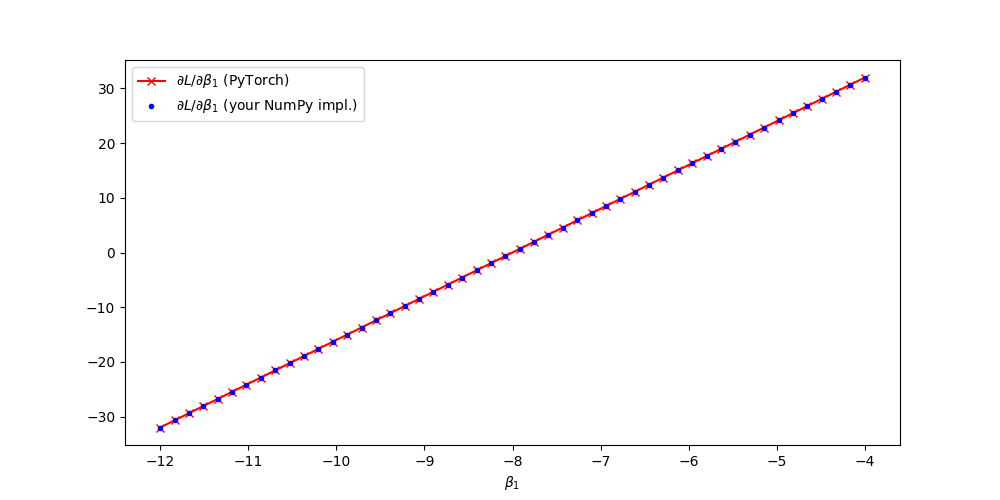

In [29]:
# Set number of points
nrof_points = 50
# Create tensors and generate range of beta1s to visualize
x_tc = torch.tensor(-2.); y_tc = torch.tensor(20.); beta0_tc = torch.tensor(4., requires_grad = True)
beta1s = np.linspace(-12, -4, nrof_points)
# Create vectors to store results
dLdbeta1_torch, dLdbeta1_np =  np.empty_like(beta1s), np.empty_like(beta1s)
# Get derivatives
for idx in range(nrof_points):
    # Initialize tensors
    beta1_tc = torch.tensor(beta1s[idx], requires_grad = True, dtype=torch.float64)
    # Perform the forward pass
    a_tc, b_tc = model_forward(x_tc, (beta0_tc, beta1_tc))
    # Compute the loss function
    L_tc = (b_tc - y_tc)**2
    # Intialize partial derivatives to zero
    try:
        beta0_tc.grad.data.zero_(); beta1_tc.grad.data.zero_()
    except:
        pass
    # Run backward pass and store result
    L_tc.backward()
    dLdbeta1_torch[idx] = np.copy(beta1_tc.grad.data.numpy())
    # Run NumPy implementation
    _, (_, dLdbeta1_np[idx]) = model_forward_backward(-2, 20, (4, beta1s[idx]))

plt.close("all")
plt.figure(figsize = [10,5], num = r"Derivative w.r.t. $\beta_1$, NumPy and PyTorch implementations")
plt.plot(beta1s, dLdbeta1_torch, 'r-x', label = r"$\partial L / \partial \beta_1$ (PyTorch)") 
plt.plot(beta1s, dLdbeta1_np, 'b.', label = r"$\partial L / \partial \beta_1$ (your NumPy impl.)")
plt.legend(); plt.xlabel(r"$\beta_1$")

<div class=" alert alert-warning">
    
<b>Note:</b> In PyTorch, to prevent the graph information from being cleared after calling <code>.backward()</code>, you need to set the <code>retain_graph</code> argument to <code>True</code> in your call. This is useful for calculating the gradients of specific applications (e.g., recursive neural networks (RNN)) that recursively use a module, but it is not needed in this lab. Experiment with it at your own risk!
</div>

#### Optimization algorithms in PyTorch

In PyTorch, one can update the learnable parameters either by explicitly implementing an optimization algorithm using the gradients, or by relying on the [`torch.optim`](https://pytorch.org/docs/stable/optim.html) module, which includes a wide variety of optimization algorithms to train neural networks, represented by `Optimizer` objects. The specific optimizer one selects within `torch.optim` (in the case of the cell below, stochastic gradient descent, `torch.optim.SGD`), requires as arguments

* a Python list of tensors representing the parameters to be trained, and 
* other parameters, which are algorithm-dependent but almost always include the learning rate `lr`. See the cell below for an example.

In order to run a step of the algorithm, and therefore update _all_ the parameters to train, one simply runs the `.step()` method of the `Optimizer` object obtained from the `torch.optim` module. This becomes extremely handy as the algorithm gets more and more involved and the number of parameters to train increases. 

#### A step of an optimization algorithm

Run the next cell to compare a step of the manually-implemented gradient descent algorithm with `torch.optim.SGD`. Make sure to understand every line of code.

<div class=" alert alert-info">
    
<b>Hint:</b> Note how the PyTorch optimizer has this extra word at the beginning, <i><a href="https://en.wikipedia.org/wiki/Stochastic_gradient_descent">stochastic</a></i>, that we had not used before. Nevertheless, in this toy example, gradient descent and <i>stochastic</i> gradient descent are the same algorithm. Do you understand why? 
</div>

In [30]:
# Set tensors to initial values
x_tc     = torch.tensor(-2, requires_grad = False, dtype=torch.float64)
beta0_tc = torch.tensor(2,  requires_grad = True,  dtype=torch.float64)
beta1_tc = torch.tensor(-4, requires_grad = True,  dtype=torch.float64)
y_tc     = torch.tensor(20, requires_grad = False, dtype=torch.float64)

# Perform the forward pass
a_tc, b_tc = model_forward(x_tc, (beta0_tc, beta1_tc))

# Compute the loss function
L_tc = (b_tc - y_tc)**2

# Perform backward pass
L_tc.backward()

# Update the weights manually
beta0_tc_updated = beta0_tc - learning_rate * beta0_tc.grad
beta1_tc_updated = beta1_tc - learning_rate * beta1_tc.grad

# Extract initial values
beta0_ini = np.copy(beta0_tc.data.numpy())
beta1_ini = np.copy(beta1_tc.data.numpy())

# Update the weights using the optimizer
optimizer = torch.optim.SGD([beta0_tc, beta1_tc], lr=learning_rate)
optimizer.step() 

print(f'Initial: β₀ = {beta0_ini}, β₁ = {beta1_ini}.')
print(f'Updated (manual): β₀ = {beta0_tc_updated.data.numpy()}, β₁ = {beta1_tc_updated.data.numpy()}.')
print(f'Updated (torch.optim.SGD): β₀ = {beta0_tc.data.numpy()}, β₁ = {beta1_tc.data.numpy()}.')

Initial: β₀ = 2.0, β₁ = -4.0.
Updated (manual): β₀ = 2.2, β₁ = -4.4.
Updated (torch.optim.SGD): β₀ = 2.2, β₁ = -4.4.


Unless told otherwise, PyTorch _accumulates_ gradients. This means that if the same model is run again forward and backward without first setting the `grad` of the relevant tensors to zero, these will then contain the sum of two gradients. This is done on purpose, since it can be useful, for example, to average the gradients of the network across data-target pairs in memory-limited systems, but you will not need it in this lab.

<div class = 'alert alert-info'>
To make sure that the gradients are not accumulated at later iterations, one needs to clear up the <code>grad</code> property of the Tensors. This is done by any <code>Optimizer</code> object by calling the <code>.zero_grad()</code> method.
</div>    

Alternatively, if one implements the optimization algorithm manually instead, one can call the `.data.zero_()` method on the `grad` property of each tensor where the gradient needs to be put to zero, as we did at the start of the sanity check above.

<div class=" alert alert-danger">
    
<b>Note:</b> Be careful to not call <code>.zero_grad()</code> before you call <code>.step()</code>! What would happen if you did? 
</div>

In [31]:
print(f"Before calling optimizer.zero_grad(), dL/dβ₀ = {beta0_tc.grad.data.numpy()} and dL/dβ₁ = {beta1_tc.grad.data.numpy()}.")
optimizer.zero_grad()
print(f"After calling optimizer.zero_grad(),  dL/dβ₀ = {beta0_tc.grad.data.numpy()} and dL/dβ₁ = {beta1_tc.grad.data.numpy()}.")

Before calling optimizer.zero_grad(), dL/dβ₀ = -20.0 and dL/dβ₁ = 40.0.
After calling optimizer.zero_grad(),  dL/dβ₀ = 0.0 and dL/dβ₁ = 0.0.


#### Experimenting with optimization algorithms in PyTorch

Run the next cell and check that the results are the same you obtained with your [Numpy implementation](#Gradient-descent). After that, feel free to experiment. 

In the next cell you will find a widget very similar to the one we used to check your implementation in NumPy, with an added dropdown menu to change the optimization algorithm. See all PyTorch optimizers [here](https://pytorch.org/docs/stable/optim.html). We didn't include *all* of them, nor used all the available parameters for each of them, but you can change the code and add any you would like to try. If you are interested, the PyTorch website has proper references to each of the optimizers. Experiment with different parameters, and feel free to change anything in the code!

<div class=" alert alert-danger">
    
<b>Note:</b> The following widget is meant to only give you a taste of the different optimizers available and how simple it is to try them out in PyTorch. However, note that the simple example we test them on is not the most relevant, and much further study and testing on real problems would be needed for you to build an intuiton on each of them.
</div>

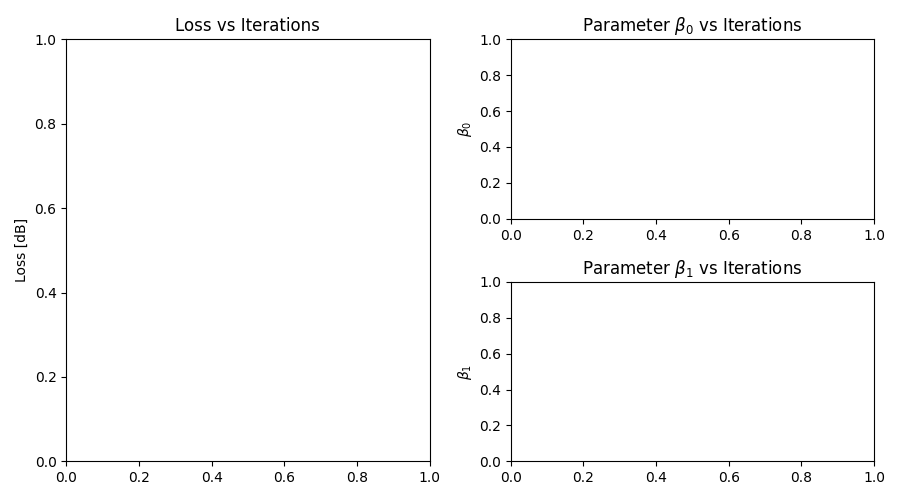

In [32]:
# Declare sliders
gamma_value = widgets.IntSlider(value = 1, min = 1, max = 10, step = 1, description = r'$\gamma$ val.')
gamma_decimal = widgets.IntSlider(value = -2, min = -4, max = 4, step = 1, description = '1E')
lr_textbox = widgets.Textarea(value = f'{10**-2:.0E}', description = r'$\gamma =$', layout = {'width': '200px', 'height': '30px'})
iterations_slider = widgets.IntSlider(value = 100, min = 10, max = 300, step = 10, description = 'Iterations')
optimizer_menu = widgets.Dropdown(options = ['SGD', 'Adagrad', 'Adam', 'Adamax', 'RProp',], 
                                  value = 'SGD', description = 'Optimizer:')
table = widgets.Textarea(value = '', layout = {'width': '55%', 'height': '300px'})
button = widgets.Button(description = 'Optimize')
button_res = widgets.Button(description='Clear Axes')
# Prepare display
box = widgets.HBox([table, widgets.VBox([gamma_value, gamma_decimal, lr_textbox, iterations_slider, optimizer_menu, button, button_res])])

# Declare figure to plot evolution of parameters
plt.close('all')
fig = plt.figure(num = "Convergence of PyTorch opti. algo.s", figsize = [9,5])
gs = fig.add_gridspec(2, 2)
ax_loss = fig.add_subplot(121); ax_loss.set_title('Loss vs Iterations'); ax_loss.set_ylabel("Loss [dB]")
ax_b0 = fig.add_subplot(222); ax_b0.set_title(r'Parameter $\beta_0$ vs Iterations'); ax_b0.set_ylabel(r'$\beta_0$')
ax_b1 = fig.add_subplot(224); ax_b1.set_title(r'Parameter $\beta_1$ vs Iterations'); ax_b1.set_ylabel(r'$\beta_1$')
plt.tight_layout(); plt.show()
display(box)

# # Declare function that performs a full pass of the gradient descent algorithm
def optimizer_full_run_pytorch(change):
    # Set tensors to initial values
    x_tc     = torch.tensor(-2,     requires_grad = False, dtype=torch.float64)
    beta0_tc = torch.tensor(2, requires_grad = True,  dtype=torch.float64)
    beta1_tc = torch.tensor(-4, requires_grad = True,  dtype=torch.float64)
    y_tc     = torch.tensor(20,     requires_grad = False, dtype=torch.float64)

    # Set learning rate, and number of iterations and printing frequency
    learning_rate = gamma_value.value * 10 ** gamma_decimal.value
    nrof_iterations = iterations_slider.value
    printing_freq = 10
    
    # Define SGD optimizer
    optim = optimizer_menu.value
    if optim == 'SGD':
        optimizer = torch.optim.SGD([beta0_tc,beta1_tc], lr=learning_rate)
    elif optim == 'Adagrad':
        optimizer = torch.optim.Adagrad([beta0_tc,beta1_tc], lr=learning_rate)
    elif optim == 'Adam':
        optimizer = torch.optim.Adam([beta0_tc,beta1_tc], lr=learning_rate)
    elif optim == 'Adamax':
        optimizer = torch.optim.Adamax([beta0_tc,beta1_tc], lr=learning_rate)
    elif optim == 'RProp':
        optimizer = torch.optim.Rprop([beta0_tc,beta1_tc], lr=learning_rate)
        
    ## Run gradient descent and print results' table
    # Prepare results' table
    table_str = '|\tIteration\t|\tβ₀\t\t\t|\tβ₁\t\t\t|\tPrevious loss (L_prev)\t|\n'+98*'-'+'\n'
    table_str += f'|\t{0:3}\t\t|\t{beta0:.4E}\t|\t{beta1:.4E}\t|\t-\t\t\t\t\t|\n'
    # Initialize variables for plots
    its, beta0s, beta1s, losses = np.arange(0,nrof_iterations+1), np.empty(nrof_iterations+1), np.empty(nrof_iterations+1), np.empty(nrof_iterations+1)
    # Fill initial values
    beta0s[0], beta1s[0] = beta0_tc.data.numpy(), beta1_tc.data.numpy()
    # Iterate
    for iter_num in range(nrof_iterations):
        # Perform the forward pass
        a_tc, b_tc = model_forward(x_tc, (beta0_tc, beta1_tc))
        # Compute the loss function
        L_tc = (b_tc - y_tc)**2
        # Perform the backward pass
        L_tc.backward()
        # Update the parameters using the optimizer
        optimizer.step() 
        optimizer.zero_grad()
        # Store values and print table row
        beta0s[iter_num+1], beta1s[iter_num+1], losses[iter_num] = beta0_tc.data.numpy(), beta1_tc.data.numpy(), L_tc.data.numpy()
        if (iter_num+1)%printing_freq == 0:
            table_str += f'|\t{iter_num+1:3}\t\t|\t{beta0s[iter_num+1]:.4E}\t|\t{beta1s[iter_num+1]:.4E}\t|\t{losses[iter_num]:.3E}\t\t\t|\n'

        # Fill last value and close table
        # Perform the forward pass
        a_tc, b_tc = model_forward(x_tc, (beta0_tc, beta1_tc))
        # Compute the loss function
        L_tc = (b_tc - y_tc)**2
        losses[-1] = L_tc.data.numpy()
    table_str += 98*'-'
    table.value = table_str
    
    ## Update plot
    ax_loss.plot(np.arange(0,nrof_iterations+1), 10*np.log10(losses), label = f'{optim} (lr={learning_rate:.0E})'); ax_loss.legend() 
    ax_b0.plot(np.arange(0,nrof_iterations+1),beta0s, label = f'{optim} (lr={learning_rate:.0E})'); ax_b0.legend() 
    ax_b1.plot(np.arange(0,nrof_iterations+1),beta1s, label = f'{optim} (lr={learning_rate:.0E})'); ax_b1.legend() 
    
def clear_axes(change):
    ax_loss.clear(); ax_loss.set_title('Loss vs Iterations'); ax_loss.set_ylabel("Loss [dB]"); ax_loss.set_xlabel("Iterations");
    ax_b0.clear(); ax_b0.set_title(r'Parameter $\beta_0$ vs Iterations'); ax_b0.set_ylabel(r'$\beta_0$')
    ax_b1.clear(); ax_b1.set_title(r'Parameter $\beta_1$ vs Iterations'); ax_b1.set_ylabel(r'$\beta_1$')

def change_lr(change):
    learning_rate = gamma_value.value * 10 ** gamma_decimal.value
    lr_textbox.value = f'{learning_rate:.0E}'

gamma_value.observe(change_lr, 'value')
gamma_decimal.observe(change_lr, 'value')
# Link buttons to functions and run once
button.on_click(optimizer_full_run_pytorch)
button_res.on_click(clear_axes)
button.click()

<div class=" alert alert-info">
    
<b>Note:</b> As you may or may not have realised, the toy example we treated in this section is a one-dimensional linear regression trained through gradient descent! You only had one data-point, however. As an extra exercise, feel free to try and see if you can modify the examples to fit a one-dimensional linear regression with several data-points you generate yourself!
</div>

## 1.B. Toy example: Logistic regression (6 points)
[Back to table of contents](#ToC_1_NN)

Let's try a slightly more complicated toy example that involves multiple composed functions, where $f(\mathbf{x},\mathbf{w}) = \operatorname{\sigma}\left(w_0x_0 + w_1x_1+w_2\right)$ and the loss function $L(\mathbf{w}) = (f(\mathbf{x},\mathbf{w})-y)^2$. Here, you will be able to appreciate even more the convenience of frameworks like PyTorch. The corresponding computational graph would be as below.

<table>
<tr>
    <td>
        <p align="center" style="padding: 10px">
            <img src="images/toy-example_logistic-regression.png" alt="Drawing" style="width: 500px;"/><br>
            <em style="color: grey">Computational graph of the network computing the logistic regression. $a$, $b$, $c$ and $o$ are highlighted points in the graph for your later use in deriving the backward pass.</em>
        </p> 
    </td>
</tr>
</table>

Here, $\mathbf{x} = [x_0,x_1]^\mathrm{T}$ is a two-dimensional input, $y$ denotes the desired output (label or target), and our goal is to find the parameter vector $\mathbf{w} = [w_0,w_1,w_2]^\mathrm{T}$ that minimizes the loss function. $\operatorname{\sigma}$ represents the sigmoid function, which is often used as a nonlinear activation function in neural networks, and is defined as

$$\operatorname{\sigma}(x) = \frac{1}{1+e^{-x}}\,.$$

In this section you will first define this more complex neural network in NumPy, and then we will do it in PyTorch.

### 1.B.a. Numpy implementation (4 points)
[Back to table of contents](#ToC_1_NN)

In this new toy example, you will be able to appreciate the modularity of backpropagation, in which the computation of the overall gradient is split in small forward and backward routines for each function used in a network, all composed in the proper order. 

From the computational graph above, it is clear that we will benefit greatly from having characterized the activation function $\operatorname{\sigma}(\cdot)$ in this way, so that we do not have to explicitly deal with the interaction between the derivatives of $L$ and those of $\sigma$. As we learned in the previous example, then, we will first build the **computational graph of the sigmoid function below**.

<table>
<tr>
    <td>
        <p align="center" style="padding: 10px">
            <img src="images/sigmoid.png" alt="Drawing" style="width: 500px;"/><br>
            <em style="color: grey">Computational graph of the sigmoid activation function $\operatorname{\sigma}(x)$. As seen in the definition of $\operatorname{\sigma}(x)$, $x$ is first multiplied by $-1$ to get $a$, then used as exponent of $e$ to get $b$, added $1$ to get $c$, and taken the reciprocal to get $o$. $a$, $b$, $c$ and $o$ are highlighted points in the graph for your later use in deriving the backward pass, different of those highlighted in the previous computational graphs. </em>
        </p> 
    </td>
</tr>
</table>

As a warm up exercise, and for **1 point, complete the backward pass through the computational graph of the sigmoid function** in the function `model_forward_backward_sigmoid` below so that it returns the partial derivatives
* `dodc`: $\partial o / \partial c$, 
* `dodb`: $\partial o / \partial b$, 
* `dbda`: $\partial b / \partial a$, and 
* `dodx`: $\partial o / \partial x$.

In [35]:
# Functions that implement the forward and backward passes of the sigmoid activation function
# Forward pass (using notation of the highlighted points in the graph above)
def model_forward_sigmoid(x):
    a = -x
    b = np.exp(np.copy(a))
    c = 1 + b
    o = 1/c
    return a, b, c, o

# Backward pass
def model_forward_backward_sigmoid(x):
    # Initialize variables (make sure to change all their values)
    dodc = None
    dodb = None
    doda = None
    dodx = None
    
    # Perform the forward pass (get a, b, c, and o in the graph above)
    a, b, c, o = model_forward_sigmoid(x)
    
    # Perform the backward pass (fill dodx using the chain rule within the computational graph above)
    dodc = -(c ** -2)
    dodb = dodc
    dbda = np.exp(a)
    dodx = - dodb * dbda

    return o, dodc, dodb, dbda, dodx

Run the cell below to see the graphs of $\operatorname{\sigma}(x)$ and $\partial \sigma/\partial x (x)$ according to your implementation of `model_forward_backward_sigmoid`. We will calculate these values for an array in the range $[-10, 10]$, to look at all the regions of interest. Verify that your results make sense! If in doubt, go ahead and look for the correct plots online.

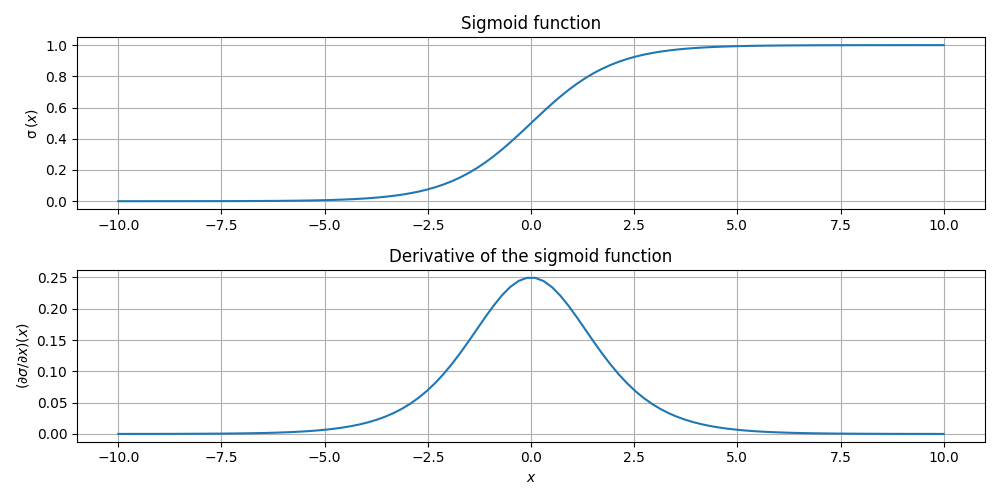

In [36]:
 # Plot the results of your model_forward_backward_sigmoid function
# Generate axis
x = np.linspace(start=-10, stop=10, num=100)
# Get results
o, dodc, dodb, dbda, dodx = model_forward_backward_sigmoid(x)

# Plot
plt.close("all")
plt.figure(figsize=[10,5])
plt.subplot(211); plt.plot(x,o); plt.ylabel(r"$\operatorname{\sigma}(x)$"); plt.grid(); plt.title('Sigmoid function')
plt.subplot(212); plt.plot(x,dodx); plt.ylabel(r"$(\partial \sigma / \partial x) (x)$"); plt.xlabel(r"$x$"); 
plt.grid()
plt.title('Derivative of the sigmoid function'); plt.tight_layout()

Although backpropagation is very advantageous when expressions can not be derived by hand, it has a cost in terms of memory and computation (and without libraries performing it for you, it can be long to implement as you have already seen). In cases in which the derivative is either well known or easy to derive, it will be beneficial to exploit it directly to obtain a more efficient implementation. 

The sigmoid function has in fact a known, closed-form expression for $\partial \sigma/\partial x$, i.e. `dodx`. In particular, we simply derive

$$\left(\frac{\partial\sigma}{\partial x}\right)(x) = \frac{\partial}{\partial x}\left\lbrace \frac{1}{1+e^{-x}}\right\rbrace = \frac{e^{-x}}{(1+e^{-x})^2} =  \left( \frac{1 + e^{-x} - 1}{1 + e^{-x}} \right) \left( \frac{1}{1+e^{-x}} \right) 
= \left[ 1 - \operatorname{\sigma}(x) \right] \operatorname{\sigma}(x)\,.$$


For **1 point**, use this result to complete the `simple_forward_backward_sigmoid` function below and ensure it matches the results of `model_forward_backward_sigmoid`. After completing it, run the cell below for a sanity check that will check both that the results match (at least partially) and that the simple implementation is faster.

<div class = 'alert alert-info'>
    
<b>Hint:</b> Use the given <code>sigmoid</code> function to calculate $\operatorname{\sigma}(x)$.
</div>
<div class = 'alert alert-danger'>
    
<b>Note:</b> Of course, you cannot call <code>model_forward_backward_sigmoid</code>.
</div>

In [37]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def simple_forward_backward_sigmoid(x):
    # Initialize o (to store forward pass)
    o = None
    # And dodx (to compute gradient)
    dodx = None
    
    # YOUR CODE HERE
    o = sigmoid(x)
    dodx = sigmoid(x) * (1 - sigmoid(x))
    
    return o, dodx

In [38]:
# Import the time library to check efficiency
import time

# Run a sanity check at hand-picked points
error_value = False
x = np.array([-5,0,5])
_, _, _, _, dodx_backprop = model_forward_backward_sigmoid(x)
_, dodx_simple = simple_forward_backward_sigmoid(x)

if not np.allclose(dodx_backprop, dodx_simple):
    print(f"Your two implementations do not seem to match. Revise your code. Using backpropagation,\ndodx = {dodx_backprop},\nwhile \
using the simple approach,\ndodx = {dodx_simple}.\n")
    error_value = True

# Compare timing using an array of nrof_points
error_time = False
nrof_reps = 1000; nrof_points = 1000
x = np.linspace(start=-10, stop=10, num=nrof_points)

start = time.time()
for ind in range(nrof_reps):
    model_forward_backward_sigmoid(x)
time_backprop = (time.time() - start)/nrof_reps
start = time.time()
for ind in range(nrof_reps):
    simple_forward_backward_sigmoid(x)
time_simple = (time.time() - start)/nrof_reps

ratio = time_backprop / time_simple

if ratio < 1:
    print("The sanity check did not pass. Revise your code to ensure the simple implementation is faster than applying the chain rule.")
    error_time = True

if not error_value and not error_time:
    print("Great, your code passed the sanity check! simple_forward_backward_sigmoid and model_forward_backward_sigmoid seem to agree, and", end=" ")
    print(f"simple_forward_backward_sigmoid is {ratio:.3} times faster than model_forward_backward_sigmoid.\n\
Average time_backprop \t= {time_backprop:.4E} s, \nAverage time_simple \t= {time_simple:.4E} s.")

Great, your code passed the sanity check! simple_forward_backward_sigmoid and model_forward_backward_sigmoid seem to agree, and simple_forward_backward_sigmoid is 1.26 times faster than model_forward_backward_sigmoid.
Average time_backprop 	= 6.2985E-05 s, 
Average time_simple 	= 4.9900E-05 s.


Now, **for 2 points**, complete a full backward chain of the toy network presented at the beginning of [this section](#1.B.-Toy-example:-Logistic-regression-(6-points)). This time, we will consider a variable number of input-target pairs `B`. For that, you will complete the function `model_forward_backward_logistic` below, which takes as parameters
* `x`: `B` input arrays $\mathbf{x}$, all in a NumPy array of shape `(B,2)`,
* `y`: `B` labels or targets, in a NumPy array of shape `(B,)`,
* `w`: the parameters' array, $\mathbf{w} = [w_0,w_1,w_2]^\mathrm{T}$, as a NumPy array of size `(3,)`,

and returns the `B` values of the loss function `L` in a NumPy array of shape `(B,)` and gradients of the loss function with respect to the trainable parameters in a NumPy array of shape `(B,3)`. 

<div class = 'alert alert-info'>
    
<b>Hints:</b> 
<ul><li>Use the <code>simple_forward_backward_sigmoid</code> function you prepared above.</li><li>For your code, do not worry much about <code>B</code>: a naïve implementation will work for any <code>B</code>, and we have handled input/output issues for you.</li></ul>
</div>

In [39]:
# perform the forward pass and backward pass (backpropagation).
def model_forward_backward_logistic(x, y, w):    
    
    # Extract inputs and weights
    x0, x1 = x[:,0], x[:,1]
    w0, w1, w2 = w
    
    # Initialize variables (make sure to change all their values)
    o, L, dLdw0, dLdw1, dLdw2 = None, None, None, None, None
    
    ## Perform the forward pass and start the backward one
    # Compute a, b, c, o, and dodc
    a = w0 * x0
    b = w1 * x1
    c = a + b + w2
    o, dodc = simple_forward_backward_sigmoid(c)
    
    # Compute the loss function
    # Place the right value in the variable L
    L = (o - y) ** 2
    
    # Perform the backward pass 
    # Place the right values in the variables dLdw0, dLdw1, and dLdw2
    
    # Backpropagate through L (compute dLdo)    
    dLdo = 2 * (o - y)
    
    # Backpropagate through the sigmoid function (compute dLdc)  
    dLdc = dLdo * dodc
    
    # Backpropagate through c (compute dLda, dLdb and dLdw2)
    dLda = dLdc
    dLdb = dLdc
    dLdw2 = dLdc
    
    # Backpropagate through a to compute dLdw0
    dLdw0 = dLda * x0
        
    # Backpropagate through b to compute dLdw1
    dLdw1 = dLdb * x1
    
    # Return predictions, loss, and gradients
    return o, L, np.hstack((np.expand_dims(dLdw0, axis=1), np.expand_dims(dLdw1, axis=1), np.expand_dims(dLdw2, axis=1)))

Now, let us apply your function to a toy dataset, $200$ points sampled from Gaussian distributions ($100$ per distribution) with $\sigma=0.25$, and with means of $[1, 1]$ and $[-1, -1]$. As you can see, there is barely any overlap, and the optimal decision boundary should be reasonably close to the linear function $y = -x$.

Run the following cell to declare and visualize this dataset.

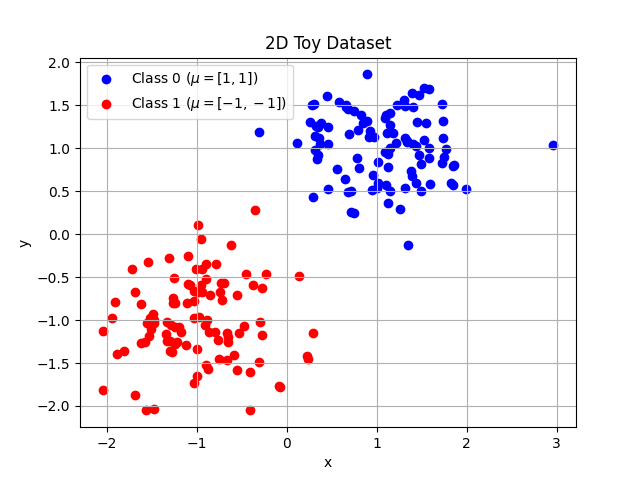

In [40]:
# Create two classes of 2D data-points
# Set the number of points per class
nrof_points_per_class = 100
# Generate the random points of both classes
x_class_0 = np.random.multivariate_normal(mean=[1,1],   cov=1/4*np.eye(2), size=(nrof_points_per_class,))
x_class_1 = np.random.multivariate_normal(mean=[-1,-1], cov=1/4*np.eye(2), size=(nrof_points_per_class,))
# Visualize the database
plt.close("all")
plt.scatter(x_class_0[:,0],x_class_0[:,1], color='blue', label = r'Class 0 ($\mu = [1, 1]$)')
plt.scatter(x_class_1[:,0],x_class_1[:,1], color='red', label = r'Class 1 ($\mu = [-1, -1]$)')
plt.grid(); plt.title('2D Toy Dataset'); plt.xlabel('x'); plt.ylabel('y'); plt.legend(); plt.show()

Now run the following cell to see the evolution of the parameters of your network when running SGD with batch size $10$ and learning rate $10^{-2}$ for $1000$ epochs.

Read the code in more detail if you are interested by an example on how one can implement SGD manually, handle batch sizes while training, understand the concept of epochs, etc.

/tmp/ipykernel_42/2357198971.py:24: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  nrof_iterations = np.ceil( 2*nrof_points_per_class*nrof_epochs/batch_size ).astype(np.int)
/tmp/ipykernel_42/2357198971.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link f

Running 20000 iterations of SGD with batch_size = 10:

| Iteration |	w₀	|	w₁	|	w₂	|	Loss	|
-------------------------------------------------------------------------
|         1 | -7.61E-04 |   +9.99E-01   |   +2.00E+00   |   +4.95E-01   |
|      1001 | -1.23E+00 |   -2.27E-01   |   +1.24E+00   |   +1.08E-01   |
|      2001 | -1.64E+00 |   -7.94E-01   |   +7.60E-01   |   +2.47E-02   |
|      3001 | -1.78E+00 |   -1.03E+00   |   +5.88E-01   |   +1.40E-02   |
|      4001 | -1.86E+00 |   -1.18E+00   |   +4.95E-01   |   +1.01E-02   |
|      5001 | -1.93E+00 |   -1.29E+00   |   +4.36E-01   |   +8.17E-03   |
|      6001 | -1.98E+00 |   -1.37E+00   |   +3.97E-01   |   +6.97E-03   |
|      7001 | -2.02E+00 |   -1.45E+00   |   +3.69E-01   |   +6.17E-03   |
|      8001 | -2.06E+00 |   -1.51E+00   |   +3.49E-01   |   +5.58E-03   |
|      9001 | -2.09E+00 |   -1.57E+00   |   +3.34E-01   |   +5.12E-03   |
|     10001 | -2.12E+00 |   -1.62E+00   |   +3.23E-01   |   +4.76E-03   |
|     11001 | -2.14E+

Text(0, 0.5, '$w_2$')

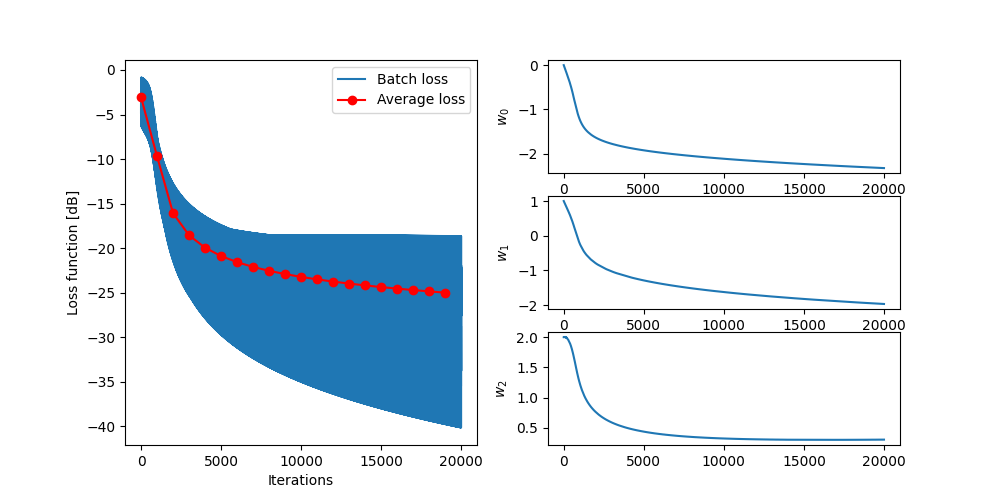

In [41]:
# Initialize x and y
x = np.empty((2*nrof_points_per_class,2)); y = np.empty((2*nrof_points_per_class,))
# Initialize grid to evaluate decision boundary
xv, yv = np.meshgrid(np.linspace(-2.5, 2.5, 200), np.linspace(-2, 2.5, 200))
X_pred = np.concatenate([xv.reshape(-1, 1), yv.reshape(-1, 1)], axis=1)
Y_pred = np.zeros((X_pred.shape[0],))
decision_boundary = []
# Get a random permutation of the indeces
perm = np.random.permutation(2*nrof_points_per_class)
# Use it to mix the two classes well
x[perm[:nrof_points_per_class],:] = x_class_0; y[perm[:nrof_points_per_class]] = np.zeros((nrof_points_per_class,));
x[perm[nrof_points_per_class:],:] = x_class_1; y[perm[nrof_points_per_class:]] = np.ones( (nrof_points_per_class,));

## Configure parameters
# Set initial parameter values
w = np.array([0, 1, 2]) 
# Set learning rate
learning_rate = 1e-2
# Set the number of epochs
nrof_epochs = 1000
# Set the batch size
batch_size = 10
# Deduce the number of iterations needed
nrof_iterations = np.ceil( 2*nrof_points_per_class*nrof_epochs/batch_size ).astype(np.int)
# Set printing frequency (approx. every 50 epochs)
printing_freq = 50*np.ceil( 2*nrof_points_per_class/batch_size ).astype(np.int)

print(f"Running {nrof_iterations} iterations of SGD with batch_size = {batch_size}:\n")

## Run stochastic gradient descent and print results' table
# Prepare results' table
print('| Iteration |\tw₀\t|\tw₁\t|\tw₂\t|\tLoss\t|\n'+73*'-')
# Initialize variables for plots
its, ws, batch_losses = np.arange(0,nrof_iterations+1), np.empty((nrof_iterations+1, 3)), np.empty(nrof_iterations)
losses = []; its_stored = []
# Fill initial value
ws[0,:] = w
# Iterate
for iter_num in range(nrof_iterations):
    # Extract corresponding batch
    indices = np.arange((iter_num-1)*batch_size, iter_num*batch_size)
    x_batch = x.take(indices = indices, mode = 'wrap', axis = 0)
    y_batch = y.take(indices = indices, mode = 'wrap', axis = 0)
    # Make a forward - backward pass
    _, L_prev, gradient = model_forward_backward_logistic(x_batch, y_batch, w)
    # Average the losses and gradients over the batch
    L_prev   = np.mean(L_prev,   axis=0)
    gradient = np.mean(gradient, axis=0)
    # Take the gradient descent step
    w = w - learning_rate * gradient
    # Store variables and inform of progress
    ws[iter_num+1,:], batch_losses[iter_num] = w, L_prev 
    if (iter_num)%printing_freq == 0:
        # Another pass just to evaluate decision boundary
        prediction_probs, _, _ = model_forward_backward_logistic(X_pred, Y_pred, w)
        decision_boundary.append(prediction_probs.reshape(xv.shape))
        its_stored.append(iter_num+1); losses.append(np.mean( model_forward_backward_logistic(x, y, w)[1], axis=0 ))
        print(f'| {iter_num+1:9} | {w[0]:+.2E} |   {w[1]:+.2E}   |   {w[2]:+.2E}   |   {losses[-1]:+.2E}   |')
# Fill last value and close table
print(73*'-')

## Plot results
plt.close("all")
plt.figure(num = "Convergence of SGD - Logistic", figsize = [10,5])
plt.subplot(121)
plt.plot(np.arange(0,nrof_iterations), 10*np.log10(batch_losses), label = "Batch loss")
plt.plot(its_stored, 10*np.log10(losses), 'ro-', label = "Average loss")
plt.legend(); plt.xlabel("Iterations"); plt.ylabel("Loss function [dB]")
plt.subplot(322)
plt.plot(np.arange(0,nrof_iterations+1),ws[:,0]); plt.ylabel(r"$w_0$")
plt.subplot(324)
plt.plot(np.arange(0,nrof_iterations+1),ws[:,1]); plt.ylabel(r"$w_1$")
plt.subplot(326)
plt.plot(np.arange(0,nrof_iterations+1),ws[:,2]); plt.ylabel(r"$w_2$")

By looking at the previous graphs, what do you think about the optimization of the parameters? It is a bit hard to make a judgement. Run the next cell to look at the evolution of the output of the network and judge by yourself! Network outputs close to $0$ are displayed in blue, while those close to $1$ are displayed in yellow. 

<div class = 'alert alert-info'>
<b>Note:</b> Click the button <code>play</code> to see the evolution of the network as an animation! Alternatively, move the slider to choose the iteration that you want to visualize.
</div>    

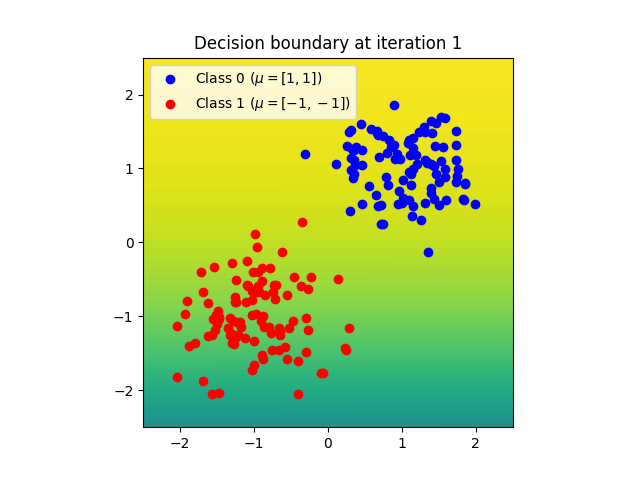

In [42]:
# Callback function for the play widget
def play_func(value):
    i = int(value['new']/10000)
    ax = plt.gca()
    ax.clear()
    # Display decision boundary
    im = ax.imshow(decision_boundary[i], origin='lower', extent=(-2.5, 2.5, -2.5, 2.5), vmin=0, vmax=1)
    # Plot the dataset points
    plt.scatter(x_class_0[:,0],x_class_0[:,1], color='blue', label = r'Class 0 ($\mu = [1, 1]$)')
    plt.scatter(x_class_1[:,0],x_class_1[:,1], color='red', label = r'Class 1 ($\mu = [-1, -1]$)')
    ax.set_xlim([-2.5, 2.5])
    ax.set_ylim([-2.5, 2.5])
    ax.set_title(f'Decision boundary at iteration {i*10000+1}')
    ax.legend()

plt.close('all')
fig, ax = plt.subplots(1)
# Initialize the figure
play_func({'new':0})
plt.show()
# Create the play widget
play = widgets.Play(value=0, min=0, max=(len(decision_boundary)-1)*10000, step=10000, interval=1000, description="Press play")
# Add callback function
play.observe(play_func, names='value')
# Add slider
slider = widgets.IntSlider(min=0, max=(len(decision_boundary)-1)*10000, step=10000)
widgets.jslink((play, 'value'), (slider, 'value'))
# Display
widgets.HBox([play, slider])

### 1.B.b. PyTorch implementation (2 points)
[Back to table of contents](#ToC_1_NN)

As we introduced in the previous toy example, we can implement the same computation graph using PyTorch. For **2 points**, complete the function `model_forward_backward_logistic_pytorch`, that computes the forward pass and the backward pass in PyTorch. It takes as parameters

* `x`: the datapoints as an array of shape `(B, 2)`,
* `y`: the class to which each datapoint belongs to (the label) as an array of shape `(B,)`,
* `w`: the parameters of the network as an array of shape `(3,)`.

Just as your function `model_forward_backward_logistic`, it returns 

* `L`: the value of the loss function,
* `(dLdw0, dLdw1, dLdw2)`: the gradient of the loss with respect to each of the parameters.


<div class = 'alert alert-success'>
<b>Hints</b>: In the next cell, you will have to:
<ul>
<li>Define the variables as PyTorch Tensors. Remember that you can use the command <code>torch.tensor</code>, and <b>don't forget about the gradient requirements!</b></li>
<li>Perform, in vectorized fashion, the appropriate computations. This step should not be very different than if you were doing it with NumPy. <ul><li><b><i>Hint: Use </i><a href="https://pytorch.org/docs/stable/generated/torch.sigmoid.html"><code>torch.sigmoid()</code></a><i> function to calculate $\sigma(\cdot)$</i></b>.</li></ul></li>
<li>Compute the loss. <b>PyTorch does not let you compute the loss of an array, so you will need the mean of the losses across the <code>B</code> data pairs</b>. <ul><li><i>Hint: you can use the method </i><a href="https://pytorch.org/docs/stable/generated/torch.mean.html"><code>.mean()</code></a> on any <code>Tensor</code>.</li></ul></li>
</ul>
</div>

In [47]:
# set the inputs into Tensors using `torch.tensor`
def model_forward_backward_logistic_pytorch(x, y, w):
    # Initialize return variables
    L_tc = dLdw0_tc = dLdw1_tc = dLdw2_tc = None
    
    # Variable names (tensors) that you will need to define: 
    # x0_tc, x1_tc, w0_tc, w1_tc, w2_tc, y_tc
    
    # x0_tc and x1_tc are given as an example. Note that this tensors store only a scalar
    x0_tc = torch.tensor(x[:, 0], requires_grad = False, dtype=torch.float64)
    x1_tc = torch.tensor(x[:, 1], requires_grad = False, dtype=torch.float64)
    w0_tc = torch.tensor(w[0], requires_grad = True, dtype=torch.float64)
    w1_tc = torch.tensor(w[1], requires_grad = True, dtype=torch.float64)
    w2_tc = torch.tensor(w[2], requires_grad = True, dtype=torch.float64)
    y_tc = torch.tensor(y, requires_grad = False, dtype=torch.float64)

    # Perform the forward pass - relevant operations with the tensors you just defined
    a = w0_tc * x0_tc
    b = w1_tc * x1_tc
    c = a + b + w2_tc
    o = torch.sigmoid(c)
    dodc = o * (1 - o)
    
    # Compute the loss
    # Variable names to define: L_tc
    L_tc = ((o - y_tc) ** 2).mean()
    
    # Perform the backward pass
    L_tc.backward(retain_graph=True)
    
    # Hint: You don't need to implement any derivative yourself, if you
    # did everything correctly, the tensors already contain it
    dLdw0_tc = w0_tc.grad.data
    dLdw1_tc = w1_tc.grad.data
    dLdw2_tc = w2_tc.grad.data
    
    return L_tc, (dLdw0_tc, dLdw1_tc, dLdw2_tc)

Does the output match with the value that you calculated previously with Numpy? Run the next cell to find out. 

<div class = 'alert alert-info'>
Note that your function <code>model_forward_backward_logistic</code> (NumPy) should return arrays of the same size as the originals, while <code>model_forward_backward_logistic_pytorch</code> returns their means. Thus, we will get the mean over the NumPy arrays and test against the results in PyTorch.
</div>

In [48]:
# First of all, lets reset the weights
w = np.array([0.5, 0.5, 0.5]) 
_, L_prev_np, gradient_np = model_forward_backward_logistic(x, y, w)
L_prev_tc, (dLdw0_tc, dLdw1_tc, dLdw2_tc) = model_forward_backward_logistic_pytorch(x, y, w)

if np.isclose(L_prev_np.mean(), L_prev_tc.data.numpy()):
    print('Well done! Your NumPy and PyTorch implementations compute the same loss.')
else:
    print('Your NumPy and PyTorch implementations do not compute the same loss, check your functions again!\
           Use the decision boundary visualization as a reference.')

if np.isclose(gradient_np[:, 0].mean(), dLdw0_tc.data.numpy()):
    print('Well done! Your NumPy and PyTorch implementations compute the same dLdw0.')
else:
    print('Your NumPy and PyTorch implementations do not compute the same dLdw0, check your functions again!\
           Use the decision boundary visualization as a reference.')
    
if np.isclose(gradient_np[:, 1].mean(), dLdw1_tc.data.numpy()):
    print('Well done! Your NumPy and PyTorch implementations compute the same dLdw1.')
else:
    print('Your NumPy and PyTorch implementations do not compute the same dLdw1, check your functions again!\
           Use the decision boundary visualization as a reference.')    
    
if np.isclose(gradient_np[:, 2].mean(), dLdw2_tc.data.numpy()):
    print('Well done! Your NumPy and PyTorch implementations compute the same dLdw2.')
else:
    print('Your NumPy and PyTorch implementations do not compute the same dLdw2, check your functions again!\
           Use the decision boundary visualization as a reference.')

Well done! Your NumPy and PyTorch implementations compute the same loss.
Well done! Your NumPy and PyTorch implementations compute the same dLdw0.
Well done! Your NumPy and PyTorch implementations compute the same dLdw1.
Well done! Your NumPy and PyTorch implementations compute the same dLdw2.


### 1.B.c. PyTorch implementation with higher abstractions
[Back to table of contents](#ToC_1_NN)

Computational graphs and autograd are a very powerful paradigm for defining complex operators and automatically taking derivatives. For large neural networks, however, raw autograd can be a bit too low-level. For example, what if the input dimension goes beyond two, like an image of size $256\times 256$? 

<div class = 'alert alert-info'>
<b>Note:</b> While throughout the course we have been treating images as $2$-dimensional objects, from a machine learning perspective each pixel corresponds to one dimension. A <i>standard</i> mobile phone has a camera resolution of 12 MP! Of course, these images are colored, so that they have 36 million dimensions! 
</div>

What if you want to change the loss function from the mean square error to the binary cross-entropy loss? What if you want to change the activation function to others such as [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU)? What if you want to use [convolutional layers](https://pytorch.org/docs/stable/nn.html#convolution-layers)?, or some new funny architectures? It would be highly inconvenient to build your model implementing all the forward and backward operations as above. 

In this example, we will show you how to use PyTorch packages for implementing our toy problem

$$f(\mathbf{x},\mathbf{w}) = \sigma\left((w_0\,x_0 + w_1\,x_1)+w_2\right)\mbox{, with }L(\mathbf{w}) = (f(\mathbf{x},\mathbf{w})-y)^2.$$

From now on, we will not consider each dimension of the inputs in the computational graph separately: instead, we can do the vector calculus with `autograd`. To do so, run the next cell to redefine our variables to a vector form. 

<div class = 'alert alert-info'>
<b>Note:</b> We split $\mathbf{w} = [w_0,w_1,w_2]^\mathrm{T}$ in the "weights", $w_0$ and $w_1$, and the "bias" terms, $w_2$. These are the common names used in machine learning.
</div>

In [49]:
# set some inputs
x_tc      = torch.tensor(x, requires_grad = False, dtype=torch.float64)
weight_tc = torch.tensor(w[:2], requires_grad = True, dtype=torch.float64)
bias_tc   = torch.tensor(w[2], requires_grad = True, dtype=torch.float64)
y_tc      = torch.tensor(y, requires_grad = False, dtype=torch.float64)
print(f'x_tc shape: {x_tc.size()}\nweight_tc shape: {weight_tc.size()}\nbias_tc shape: {bias_tc.size()}\ny_tc shape: {y_tc.size()}')

x_tc shape: torch.Size([200, 2])
weight_tc shape: torch.Size([2])
bias_tc shape: torch.Size([])
y_tc shape: torch.Size([200])


#### [`torch.nn`](https://pytorch.org/docs/stable/nn.html)

In PyTorch, the `torch.nn` (full documentation [here](https://pytorch.org/docs/stable/nn.html)) package provides higher-level abstractions over raw computational graphs that are useful for building neural networks. The `nn` package defines a set of `Modules`, which are roughly equivalent to neural network layers. A `Module` receives input Tensors and computes output Tensors, but may also hold an internal state such as Tensors containing learnable parameters. The nn package also defines a set of useful [loss functions](https://pytorch.org/docs/stable/nn.html#loss-functions) and [activation functions](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) that are commonly used when training neural networks.

Here, we will use the `nn` package to define our model as a sequence of layers. In brief [`torch.nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) (one of the modules you will use the most in your deep learning journey) is a module which contains other modules, and applies them in sequence to produce its output.

<div class = 'alert alert-success'>
So yes, as you have guessed, it is possible to define and train huge neural networks, with millions of parameters in relatively few lines of code. We are sorry for making you implement everything manually, but we hope that you feel entirely comfortable with the concepts of backpropagation and optimization. That will certainly help you follow the next parts of the lab.  
</div>

#### Define a model
In our case, we will use `torch.nn.Linear` and `torch.nn.Sigmoid` modules. The [Linear module](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) computes output from input using a linear function, and holds internal Tensors for its `weight` and `bias`. The [Sigmoid module](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html#torch.nn.Sigmoid) applies the sigmoid function to the output of the previous Linear module. Run the next cell to define your Sequential model with one Linear layer (with 2 inputs and 1 output) and one Sigmoid layer.

In [50]:
# Instantiate Sequential object
model = torch.nn.Sequential(
    # Declare Linear layer with 2 inputs and one output
    torch.nn.Linear(in_features=2, out_features=1, bias=True),
    # Declare sigmoid function
    torch.nn.Sigmoid()
)

# Cast the parameters of the model in float64 format to match it with the input format.
model.double() 
print(model)

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)


As you can see, in the `Sequential` module we have included two further modules, `Linear` and `Sigmoid`. You can call each module of your model by *normal* indexing; in the last cell, `model` is an iterable where the $i^{\mathrm{th}}$ element is the $i^{\mathrm{th}}$ module defined. For example, the first module of our model is a `Linear` module which takes a two-dimensional input and outputs a one-dimensional feature. You can call and even set its `weight` and `bias` with specific values. 

Run the next cell and do some exploration on `model`! Take inspiration from the few lines that we already wrote.

<div class = 'alert alert-success'>
If you took <a href="https://moodle.epfl.ch/enrol/index.php?id=522" >IP1</a>, you probably feel comfortable with manipulating NumPy Arrays. 
    
Maybe now is the time to start exploring Tensor methods (class reference [here](https://pytorch.org/docs/master/tensors.html#tensor-class-reference)). There are a lot of operations you can apply to a Tensor, e.g. <code>t = t.add(1)</code> will add $1$ to the tensor <code>t</code> (with <code>t.add_(1)</code> being the in-place version, meaning that there is no need to reassign the value). Almost any operation you can think of (e.g., absolute value, exponential) can be applied this way. 
</div>

In [51]:
# Let's do some exploration
print('Linear layer: ', model[0]) # Try print(model[1])
print('\nInitial weights: ', model[0].weight) # Try print(model[1])
print('\nInitial bias: ', model[0].bias) # Try print(model[1])

# Now let's try to modify the bias. First we set it to 1
model[0].bias = torch.nn.Parameter(torch.empty((1,)).fill_(1))
print('\nNew bias: ', model[0].bias) # Try print(model[1])

# Now let's set the values of the variable bias = w2
model[0].bias.data = bias_tc

# Great! Keep on with the exploration!

# Try print(model[1])

# Try to set the values of the variables weight = weight_tc = (w0, w1)

print('\nNew weights: ', model[0].weight) # Try print(model[1])
print('\nNew bias: ', model[0].bias) # Try print(model[1])

Linear layer:  Linear(in_features=2, out_features=1, bias=True)

Initial weights:  Parameter containing:
tensor([[-0.5767,  0.4685]], dtype=torch.float64, requires_grad=True)

Initial bias:  Parameter containing:
tensor([0.4268], dtype=torch.float64, requires_grad=True)

New bias:  Parameter containing:
tensor([1.], requires_grad=True)

New weights:  Parameter containing:
tensor([[-0.5767,  0.4685]], dtype=torch.float64, requires_grad=True)

New bias:  Parameter containing:
tensor(0.5000, dtype=torch.float64, requires_grad=True)


#### The forward pass

The forward pass is now straighforward: You can simply give the input as an argument to the model. You can even separately access to the intermediate layers and their outputs.

Run the next cell, and go through every line on it to see how to do this.

In [52]:
# 1
output_1st_layer = model[0](x_tc)
output_2nd_layer = model[1](output_1st_layer)

# 2
output = model(x_tc)

# Comparison (print the number of elements different from zero in the array #1 - #2)
np.count_nonzero(output_2nd_layer.data.numpy() - output.data.numpy())

0

#### Define different loss functions

It is also very easy to set a loss function using `torch.nn`. PyTorch provides a list of loss functions that are frequently used for training neural networks, you can check the reference [here](https://pytorch.org/docs/stable/nn.html#loss-functions). There, you will also find further documentation on the different functions.

Run the next cell to compute the `Mean Squared Error`, the loss we have been using, using `torch.nn` and perform the backward pass on it.

In [53]:
# Set the loss function
loss_fn = torch.nn.MSELoss()

# Compute the loss (flatten to reduce the extra dimension)
L_tc = loss_fn(output.flatten(), y_tc)

# Perform the backward pass
try:
    L_tc.backward()
except:
    raise Exception("WARNING:\nRun the forward pass in the previous cell again if you want to evaluate \
the backward pass a second time.")
    
print(L_tc.data.numpy())

0.2440357668048869


Now that we have ran `L_tc.backwards`, let's look at the gradients again. They are now multi-dimensional tensors, as they should!

In [54]:
print('[PyTorch results] dL/dw₀: %.4f, dL/dw₁: %.4f, dL/dw₂: %.4f, L: %.4f \n' % (model[0].weight.grad.data[0][0], model[0].weight.grad.data[0][1], model[0].bias.grad.data,L_tc.data))
print('Note that now your gradient is stored as a single array: \ndL/dw: %s \ndL/db: %s'% (model[0].weight.grad.data[0].numpy(), model[0].bias.grad.data.numpy()))

[PyTorch results] dL/dw₀: 0.2102, dL/dw₁: 0.2307, dL/dw₂: 0.0556, L: 0.2440 

Note that now your gradient is stored as a single array: 
dL/dw: [0.21018252 0.23073936] 
dL/db: 0.05563272763898931


<div class=" alert alert-info">
    
**Note:** Even though the objects and shapes are different, do the output results match with the previous results ([NumPy](#1.B.a.-Numpy-implementation-(4-points)) and [PyTorch](#1.B.b.-PyTorch-implementation-(2-points)) implementations)?
</div> 

# 2. Binary Classification
[Back to table of contents](#ToC_1_NN)

It is a common wisdom in deep learning that one needs to go deeper (more layers) to learn a complex function such as an image classifier. However, managing the computational graph becomes very difficult as the network architecture becomes more complicated and the number of parameters increases. Thus, implementing such a network with Numpy is neither feasible (don't worry, we won't make you code a multilayer binary classifier in NumPy) nor efficient. In this section, we will implement a whole pipeline for training a binary classifier using PyTorch. 

## Data preparation and visualization
### Creating a two moon dataset

We will take advantage of this section to introduce the library [Scikit Learn](https://scikit-learn.org/stable/). Just as Scikit Image, it is one of the [Scipy Kits](https://www.scipy.org/scikits.html) that builds on top of the core modules of SciPy for a specific application, in this case, machine learning. Scikit Learn provides everything from implementation of machine learning algorithms, to standard toy datasets and functions for common data preprocessing. 

For this toy example, we will train a network that takes two-dimensional coordinates and classifies them into two classes. To this end, we will use a two moon dataset that we will generate with the function [`make_moons`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) in the [`sklearn.datasets`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets) package and split the samples into a training and a test dataset (we are sure you have heard about this before, but here is a crash course [here](https://developers.google.com/machine-learning/crash-course/training-and-test-sets/video-lecture) on the concept) using `train_test_split` in the `sklearn.model_selection` package (please refer to the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) for a complete reference). This function splits the data randomly into two sets according to the ratio that we choose. One set will be used during *training*, and a second that will be used to *test* the quality of the resulting model in data it has not been trained on.

Run the next cell to create and split the data set.

In [55]:
# number of samples in the data set
nb_samples = 1000
# ratio between training and test sets
test_size = 0.1

# Create data set
X, y = make_moons(n_samples = nb_samples, noise=0.2, random_state=100)
# Add dimension to y for later use 
y = y.reshape((-1,1))
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
print('X train shape: ', X_train.shape, '\nX test shape: ', X_test.shape)
# Take a look at a point
print(f'\nSample point:\n(x1,x2) coordinates: {X[0]}, y label: {y[0]}')

X train shape:  (900, 2) 
X test shape:  (100, 2)

Sample point:
(x1,x2) coordinates: [2.24907069e-05 1.07275825e+00], y label: [0]


As you can see, our data consists of coordinate pairs (corresponding to `X`) that belong to a class (specified by `y`).

Run the next cells and check how the data looks like. 

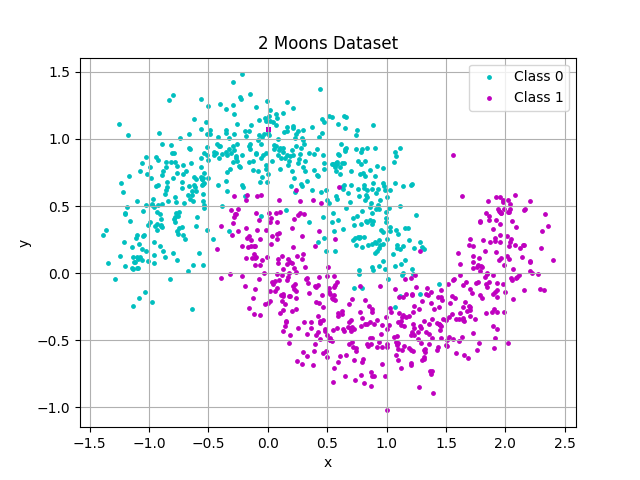

In [56]:
plt.figure()
# Plot class zero
idx_0 = np.where(y == 0)
plt.scatter(X[idx_0, 0], X[idx_0, 1], s = 6, color = 'c', label = 'Class 0')
# Plot class one
idx_1 = np.where(y == 1)
plt.scatter(X[idx_1, 0], X[idx_1, 1], s = 6, color = 'm', label = 'Class 1')
# Set labels, title, grid and legend
plt.ylabel('y'); plt.xlabel('x'); plt.title('2 Moons Dataset'); plt.grid(); plt.legend(); plt.show()

As you can see, this data set is far more interesting than the ones we have been working with before. The boundary is evidently not linear, and the two classes are not perfectly separable with a smooth curve, as there is some overlap between the sets. Nonetheless, there is a clear boundary and it is still only 2D, so deep learning should be able to handle it. On to the fun part.

## 2.A. PyTorch Implementation (9 points)
[Back to table of contents](#ToC_1_NN)

In this section, you will code a small (yet more complex than the ones we have been working on) neural network with PyTorch. This section will allow you to interact by yourself with the [`torch.nn`](https://pytorch.org/docs/stable/nn.html) module and all its functionalities, and get used to the process of developing a neural network from scratch with PyTorch. 

First, run the next cell to convert our data points to tensors. Pay attention to all the parameters!

In [57]:
# Set the values of input variables
X_train_tc = torch.tensor(X_train, requires_grad = False, dtype=torch.float64)
X_test_tc = torch.tensor(X_test, requires_grad = False, dtype=torch.float64)
y_train_tc = torch.tensor(y_train, requires_grad = False, dtype=torch.float64)
y_test_tc = torch.tensor(y_test, requires_grad = False, dtype=torch.float64)

Now you need to define a model. Use the `torch.nn.Sequential` module to build the model with the following specifications:

```python
NN_ARCHITECTURE = [
    {"input_dim": 2, "output_dim": 25, "activation": "relu"},
    {"input_dim": 25, "output_dim": 50, "activation": "relu"},
    {"input_dim": 50, "output_dim": 25, "activation": "relu"},
    {"input_dim": 25, "output_dim": 1, "activation": "sigmoid"},
]
```

Specifically, this model starts with a linear layer of `in_features = 2` and `out_features = 25` followed by the activation function [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html), which is [the most popular activation function](https://towardsdatascience.com/understanding-relu-the-most-popular-activation-function-in-5-minutes-459e3a2124f) for building modern deep neural networks: 

$$ReLU(x)=(x)_+ =\max\,(0,x)$$

<div style="text-align:center">
    <img src="images/ReLU.png" alt="Drawing" style="width: 500px;"/>
</div>

The model finishes with the sigmoid function so that it outputs the value between 0 and 1, which can be interpreted as a probability. 
You will need to use `torch.nn.Linear`, `torch.nn.ReLU()`, and `torch.nn.Sigmoid()` modules in order.

For **2 points**, code the function `build_model`, that takes no parameters and returns a `model` with the specified characteristics

In [58]:
# Declare function build model
def build_model():
    model = None
    in_channels = 2
    out_channels = 1
    
    model = torch.nn.Sequential(
        torch.nn.Linear(in_channels, 25),
        torch.nn.ReLU(inplace=True),
        torch.nn.Linear(25, 50),
        torch.nn.ReLU(inplace=True),
        torch.nn.Linear(50, 25),
        torch.nn.ReLU(inplace=True),
        torch.nn.Linear(25, out_channels),
        torch.nn.Sigmoid()
    )
    
    # Cast model parameters to float64
    model.double()
    return model

Let's run your function and print the resulting model. Look back at the architechture we proposed and check that it is correct. Then we will make some tests on your architecture, to make sure that it is correct. 

In [59]:
model = build_model()
print(model)

# Check that the model has 5 layers
assert len(model._modules.items()) == 8, f'The model should have 8 layers: 4 linear, 3 ReLU and 1 Sigmoid. Yours currently has {len(model._modules.items())} layers.'
# Check that the layer types are correct
for i, layer in enumerate(model._modules.items()):
    current_layer = torch.nn.modules.linear.Linear if i % 2 == 0 else torch.nn.modules.activation.ReLU
    if i == 7: current_layer = torch.nn.modules.activation.Sigmoid 
    assert type(layer[1]) == current_layer, f'Layer {i} should be of type {current_layer}, not {type(layer[1])}.'
# Check that the input and output size of the layers is correct and that torch.nn.Sequential was used
for i, module in enumerate(model.modules()):
    if i == 0:
        assert type(module) == torch.nn.modules.container.Sequential, 'You should use torch.nn.Sequential to build your model!'
    if i == 1:
        assert module.in_features == 2, f'The input size of layer {i-1} ({module.in_features}) is not correct. Remember that we are trying to classify a 2D dataset.'
        assert module.out_features == 25, f'The output size of layer {i-1} ({module.out_features}) is not correct. Remember that the first hidden layer should be of size 25.'
    if i == 3:
        assert module.in_features == 25, f'The input size of layer {i-1} ({module.in_features}) is not correct. Remember that the first hidden layer should be of size 25.'
        assert module.out_features == 50, f'The output size of layer {i-1} ({module.out_features}) is not correct. Remember that the second hidden layer should be of size 50.'
    if i == 5:
        assert module.in_features == 50, f'The input size of layer {i-1} ({module.in_features}) is not correct. Remember that the second hidden layer should be of size 50.'
        assert module.out_features == 25, f'The output size of layer {i-1} ({module.out_features}) is not correct. Remember that the third hidden layer should be of size 25.'
    if i == 7:
        assert module.in_features == 25, f'The input size of layer {i-1} ({module.in_features}) is not correct. Remember that the third hidden layer should be of size 25.'
        assert module.out_features == 1, f'The output size of layer {i-1} ({module.out_features}) is not correct. We will classify with a scalar between 0 and 1, so we need one single output.'

print('Well done! The model seems to be correct.')

Sequential(
  (0): Linear(in_features=2, out_features=25, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=25, out_features=50, bias=True)
  (3): ReLU(inplace=True)
  (4): Linear(in_features=50, out_features=25, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=25, out_features=1, bias=True)
  (7): Sigmoid()
)
Well done! The model seems to be correct.


PyTorch provides a list of loss functions that are frequently used for training neural networks: [torch.nn loss functions](https://pytorch.org/docs/stable/nn.html#loss-functions). Since we are solving the binary classification problem, we need a binary cross entropy (BCE) loss (full documentation [here](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)), which you will explore in more detail in the second notebook of this lab. 

To optimize the model parameters, we can use [torch.optim](https://pytorch.org/docs/stable/optim.html). Here, we will use [torch.optim.SGD](https://pytorch.org/docs/master/generated/torch.optim.SGD.html) and [torch.optim.Adam](https://pytorch.org/docs/master/generated/torch.optim.Adam.html) for training our toy network. 

In the next cell, **for 2 points**, code the functions `define_loss` and `define_optimizers`, **1 point each**.

* `define_loss` has no input parameters, and should return the `torch` module `BCELoss`,
* `define_optimizer` has as input parameters `model` (a PyTorch model) and `learning_rate` (scalar, self-explanatory) , and should return the `torch` module `SGD`,

<div class = 'alert alert-success'>
<b>Hint:</b> As we showed in the previous exercises, one needs to specify the model parameters that are to be trained. In PyTorch, one can call the parameters of a Module by <code>.parameters()</code>. For example, since we want to train the entire trainable parameters that are included our <code>model</code> (Sequential Module), we can use <code>model.parameters()</code>. 
</div>

Complete the two functions and then run the following cells for some sanity checks.

In [60]:
# Declare loss function
def define_loss():
    bce_loss = None
    
    # set the loss function bce_loss
    bce_loss = torch.nn.BCELoss()
    
    return bce_loss

def define_optimizer(model, learning_rate):
    optimizer = None  
    
    # set the SGD optimizer with the given learning rate for the model 
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    return optimizer

<div class=" alert alert-info">
    
<b>Hint</b>: Apart from the instantiation of the variable and the return value, both of your functions above should be one-liners. 
</div>

Run the next two cells to examine your loss function and optimizer.

In [61]:
# Examine loss. First, we declare it
bce_loss = define_loss()
if not bce_loss.__module__ == 'torch.nn.modules.loss': print('Your loss does not seem to be a PyTorch loss module!')
elif not 'BCE' in str(bce_loss):  print('Your loss is a PyTorch loss module, just not the correct one.')
else: print('Great! You\'re on the right track for building your network.')

Great! You're on the right track for building your network.


In [62]:
# Examine loss. First, we declare it
optimizer = define_optimizer(model, 0.01)

if 'torch.optim' not in optimizer.__module__: print('Your optimizer does not seem to be a PyTorch optimizer module!')
elif not 'sgd' in optimizer.__module__:  print('Your optimizer is a PyTorch optimizer, just not the correct one.')
else: print('You\'re really close from finishing your network!.')

You're really close from finishing your network!.


Now we have all the ingredients to train the network. Make sure that you pass the previous sanity checks, as the performance of your network depends on it!

In the next cell, for **5 points** complete the function `train`. It takes as input parameters:

* `X_train_tc`: (of shape `(n, 2)`): the data points.
* `y_train_tc`: (of shape `(n, 1)`): the true class of each of the data points.
* `model`: a PyTorch model, e.g. the output of your function `build_model`.
* `optimizer`: a PyTorch optimizer, e.g. the output of your function `define_optimizer`.
* `loss_fn`: a PyTorch loss function, e.g. the output of your function `define_loss`.
* `epochs`: Number of times that the optimizer will go through the whole data set.

It returns the variables `y_pred` and `loss`, the predictions and loss of the last epoch (on the training set). Note that there is no need to return the model, as it should directly modify the parameters of the model given as parameter.

<div class='alert alert-success'>
<b>Hints</b>
In the function <code>train</code>, you will have to perform the following tasks (in order):
<ol><li>Perform a forward pass,</li>
<li>Calculate the loss between the predicted and the true values</li>
<li>Perform the backward pass</li>
<li>Update the parameters of your model</li>
<li>Reset the gradients of the parameters to $0$</li></ol>
    
Note that all of this tasks are one-liners. In 2 of them, you need to perform an assignment. On the other three, you need to call methods of the parameters of the function `train`. Only the highest level of abstraction of PyTorch is accepted! (Anyway, we don't think you will want to perform the backward pass manually).
</div>

In [65]:
def train(X_train_tc, y_train_tc, model, optimizer, loss_fn, epoch, verbose=True, save_preds=None):
    # Prepare grid to evaluate the decision boundary for later visualization
    if save_preds != None:
        xv, yv = np.meshgrid(np.linspace(-1.5, 2.5, 201), np.linspace(-1, 1.5, 126))
        X_pred = np.concatenate([xv.reshape(-1, 1), yv.reshape(-1, 1)], axis=1)
    # Print divisor
    div = 1 if epoch < 10 else epoch//10
    
    for iter_num in range(epoch):
        
        # perform the forward pass
        y_pred = None
        model.train()
        y_pred = model(X_train_tc)

        # compute the loss in the variable loss
        loss = None
        loss = loss_fn(y_pred, y_train_tc)

        # perform the backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # update the parameters
        optimizer.step()

        # clear up the accumulated gradients
        optimizer.zero_grad()
        model.eval()
        
        # print loss
        if iter_num % div == 0:    
            if verbose:
                y_pred_test = model(X_test_tc)
                pred = y_pred_test >= 0.5
                truth = y_test_tc >= 0.5
                acc = pred.eq(truth).sum().item() / truth.numel()
                print(f'iteration {iter_num}, loss: {loss:4f}, test accuracy: {acc:4f}')
        if iter_num % 2 == 0:
            if save_preds != None:                
                prediction_probs = model(torch.tensor(X_pred, dtype=torch.float64))
                save_preds.append(prediction_probs.data.numpy().reshape(xv.shape))
        model.train()
    return y_pred, loss

<div class=" alert alert-info">

<b>Note:</b> You might have noticed that there are some new attributes <code>eval()</code> and <code>train()</code> that we used inside the if statement for printing the results. `model.eval()` tells the model that you are now in the testing mode, and <code>model.train()</code> simply tells it that you are in the training mode. This becomes important for more complex layers like <a href = "https://jmlr.org/papers/v15/srivastava14a.html"><code>dropout</code></a> or <a href = "http://proceedings.mlr.press/v37/ioffe15.html"><code>batchnorm</code></a> (both out of the scope of the course, but you can check out the original articles on the links), which behave differently for the train and test procedures. In fact, we do not need these for our toy model since it does not have such layers. However, we included here to show you that it is always recommended to specify whether your model is under the training mode or testing mode in practice. 
</div> 

We hope that it didn't take too long. Run the next cell to see whether everything is correct by running your function for 20 epochs.

In [66]:
print("Train network for 20 epochs.")
# Discard the output
_, _ = train(X_train_tc, y_train_tc, model, optimizer, bce_loss, epoch=20)
print("\nGood job! Seems like your function runs smoothly.")
print("Is it actually doing something though?")

Train network for 20 epochs.
iteration 0, loss: 0.696496, test accuracy: 0.540000
iteration 2, loss: 0.696272, test accuracy: 0.540000
iteration 4, loss: 0.696048, test accuracy: 0.540000
iteration 6, loss: 0.695826, test accuracy: 0.540000
iteration 8, loss: 0.695602, test accuracy: 0.540000
iteration 10, loss: 0.695377, test accuracy: 0.540000
iteration 12, loss: 0.695153, test accuracy: 0.540000
iteration 14, loss: 0.694927, test accuracy: 0.540000
iteration 16, loss: 0.694700, test accuracy: 0.540000
iteration 18, loss: 0.694473, test accuracy: 0.540000

Good job! Seems like your function runs smoothly.
Is it actually doing something though?


Did you see anything interesting? No? Let's just try again, why not. Run the following cell. 

In [67]:
print("Train network for 10 more epochs.")
# Discard the output
_, _ = train(X_train_tc, y_train_tc, model, optimizer, loss_fn, epoch=10)
print("\nStill running.")
print("Any further changes?")

Train network for 10 more epochs.
iteration 0, loss: 0.250549, test accuracy: 0.540000
iteration 1, loss: 0.250521, test accuracy: 0.540000
iteration 2, loss: 0.250493, test accuracy: 0.540000
iteration 3, loss: 0.250465, test accuracy: 0.540000
iteration 4, loss: 0.250437, test accuracy: 0.540000
iteration 5, loss: 0.250410, test accuracy: 0.540000
iteration 6, loss: 0.250382, test accuracy: 0.540000
iteration 7, loss: 0.250354, test accuracy: 0.540000
iteration 8, loss: 0.250326, test accuracy: 0.540000
iteration 9, loss: 0.250298, test accuracy: 0.540000

Still running.
Any further changes?


Sorry, we are not going to make you run the same cell pointlessly. In fact, with the learning rate we have chosen, SGD can take quite a long time. Just for the purpose of seeing that it actually works, run the next cell, where we will run it for a few more epochs than before. 

In [68]:
print("Just run it for 500 epochs already.")
# Discard the output
_, _ = train(X_train_tc, y_train_tc, model, optimizer, loss_fn, epoch=500)
print("\nStill running.")
print("Now it's changing.")

Just run it for 500 epochs already.
iteration 0, loss: 0.250271, test accuracy: 0.540000
iteration 50, loss: 0.248930, test accuracy: 0.540000
iteration 100, loss: 0.247633, test accuracy: 0.540000
iteration 150, loss: 0.246353, test accuracy: 0.540000
iteration 200, loss: 0.245086, test accuracy: 0.550000
iteration 250, loss: 0.243764, test accuracy: 0.700000
iteration 300, loss: 0.242340, test accuracy: 0.760000
iteration 350, loss: 0.240785, test accuracy: 0.800000
iteration 400, loss: 0.239061, test accuracy: 0.800000
iteration 450, loss: 0.237118, test accuracy: 0.790000

Still running.
Now it's changing.


As you can see, SGD does work, the loss will decreases but very slowly. If we had a huge dataset of thousands of dimensions (basically any image processing problem), we would appreciate something faster. Now, let's try a different optimizer, `torch.optim.Adam` with default settings. Adam optimizer uses the notion of momentum, which is known to accelerate the training process. For more detailed explanation, please check [torch.optim.Adam](https://pytorch.org/docs/master/generated/torch.optim.Adam.html). 

Run the next cell to reset the parameters of your model, and declare a new optimizer in the variable `optimizer_adam` (no need to declare a function or anything, just define the optimizer). This will count for **1 point**, in combination with its proper use in the function `train`.

In [69]:
# Let's first reset the parameters for a fair comparison.
for layer in model.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()
        
# Set the Adam optimizer with the given learning rate (learning_rate)
optimizer_adam = None

# YOUR CODE HERE
optimizer_adam = torch.optim.Adam(model.parameters(), lr=learning_rate)

Just for a very quick test, run the next cell to explore your optimizer.

In [70]:
# Look at your optimizer
print(optimizer_adam)
# Check that it is the correct one
if not 'Adam' in str(optimizer_adam): 
    print('Your optimizer does not seem to be the correct one!')
else: 
    print('Well done! You now know 2 of the most important optimizers in deep learning.')

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)
Well done! You now know 2 of the most important optimizers in deep learning.


Run the next cell and check the effect of using different optimizers. Note how we are only training for 50 epochs.

In [71]:
decision_boundary_preds = []
# Run with Adam optimizer 
_, _ = train(X_train_tc, y_train_tc, model, optimizer_adam, loss_fn, epoch=50, save_preds=decision_boundary_preds)

iteration 0, loss: 0.246459, test accuracy: 0.800000
iteration 5, loss: 0.169490, test accuracy: 0.790000
iteration 10, loss: 0.110321, test accuracy: 0.810000
iteration 15, loss: 0.092895, test accuracy: 0.840000
iteration 20, loss: 0.078283, test accuracy: 0.850000
iteration 25, loss: 0.067906, test accuracy: 0.880000
iteration 30, loss: 0.057302, test accuracy: 0.900000
iteration 35, loss: 0.043720, test accuracy: 0.940000
iteration 40, loss: 0.033103, test accuracy: 0.980000
iteration 45, loss: 0.026992, test accuracy: 0.980000



<div class=" alert alert-info">

<b>PyTorch appreciation:</b> Imagine how difficult it would have been if you had to implement all these in Numpy while keeping the framework flexible to different architectures (e.g., layers, feature dimensions, etc.) and taking care of all the forward and backward passes in a concise manner. 
<!-- There are two goals in this exercise. One is to go over the entire learning process with PyTorch, and the other is to demonstrate how much easier it can be to implement the network using PyTorch than using a pure Numpy.  
     -->
</div> 


## 2.B. Visualization
[Back to table of contents](#ToC_1_NN)

For the final section of the lab, we want you to take a look at the evolution of the decision boundary. Run the next cell, and play with the gif to see this evolution throughout the 50 epochs of training with Adam. 

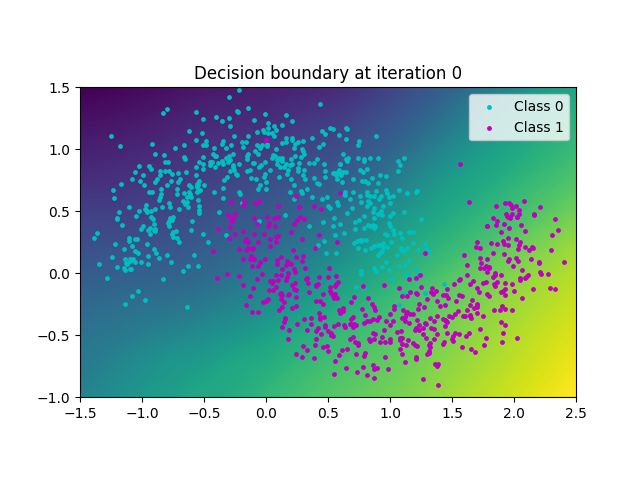

In [72]:
# Callback function for the play widget
def play_func(value):
    i = int(value['new'] // 2)
    ax = plt.gca()
    ax.clear()
    # Display decision boundary
    ax.imshow(decision_boundary_preds[i], origin='lower', extent=(-1.5, 2.5, -1, 1.5))
    # Plot the dataset points
    idx_0 = np.where(y == 0)
    ax.scatter(X[idx_0, 0], X[idx_0, 1], s = 6, color = 'c', label = 'Class 0')
    idx_1 = np.where(y == 1)
    ax.scatter(X[idx_1, 0], X[idx_1, 1], s = 6, color = 'm', label = 'Class 1')
    ax.set_xlim([-1.5, 2.5])
    ax.set_ylim([-1, 1.5])
    ax.set_title(f'Decision boundary at iteration {2*i}')
    ax.legend()

plt.close('all')
# Initialize the figure
fig, ax = plt.subplots(1)
play_func({'new':0})
plt.show()
# Create the play widget
play = widgets.Play(value=0, min=0, max=(len(decision_boundary_preds)-1)*2, step=2, interval=1000, description="Press play")
# Add callback function
play.observe(play_func, names='value')
# Add slider
slider = widgets.IntSlider(min=0, max=(len(decision_boundary_preds)-1)*2, step=2)
widgets.jslink((play, 'value'), (slider, 'value'))
# Display
widgets.HBox([play, slider])

<div class=" alert alert-info">
<h4>Explore!</h4>
Try with different setups such as different number of layers, feature dimensions, activation functions, etc., and see how it goes. 
    
</div> 

<div class="alert alert-success">
    
<p><b>Congratulations on finishing the first part of the Neural Networks lab!</b></p>
<p>
Make sure to save your notebook (you might want to keep a copy on your personal computer) and upload it to <a href="https://moodle.epfl.ch/mod/assign/view.php?id=1157357">Moodle</a>, in a zip file with other notebooks of this lab.
</p>
</div>

* Keep the name of the notebook as: *1_NN_Basics.ipynb*,
* Name the zip file: *Neural_Networks_Lab.zip*.

<div class="alert alert-danger">
<h4>Feedback</h4>
    <p style="margin:4px;">
    This is the first edition of the image-processing laboratories using Jupyter Notebooks running on Noto. Do not leave before giving us your <a href="https://moodle.epfl.ch/mod/feedback/view.php?id=1157363">feedback here!</a></p>
</div>